<a href="https://colab.research.google.com/github/MHH9791/continual_learning_with_neural_net_models/blob/main/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# General import

In [ ]:
from time import time
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import gzip
import json

In [ ]:
import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing import sequence, text

In [ ]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.layers.core import Dense,Activation,Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras.models import load_model

In [ ]:
def printAccuracy(y_pred, Y_test):
  acc = accuracy_score(Y_test, y_pred)
  return acc

In [ ]:
def plot_acc_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
  plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.figure()
  plt.plot(epochs, loss, 'bo', label = 'Training Loss')
  plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
unks = []
UNKS = []

def cleared(word):
  res = ""
  prev = None
  for char in word:
    if char == prev: continue
    prev = char
    res += char
  return res

In [ ]:
def sentence_to_indices(sentence_words, word_to_index, i):
  global X, Y
  sentence_indices = []
  for j, w in enumerate(sentence_words):
    try:
      index = word_to_index[w]
    except:
      UNKS.append(w)
      w = cleared(w)
      try:
        index = word_to_index[w]
      except:
        index = word_to_index['unk']
        unks.append(w)
    X[i, j] = index

# Dataset selection and discovery

The first dataset is about amazon reviews for electronic devices, which contains 1,689,188 reviewing samples. The second dataset is about reviews for movies and TV, which contains 1,697,533 reviewing samples. Reference: [Amazon reviews site](http://jmcauley.ucsd.edu/data/amazon/index_2014.html)

In [ ]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

### **Load from ZIP for electronics**

In [ ]:
df_raw_electronics = getDF('/content/drive/MyDrive/Colab Notebooks/nlp/reviews_Electronics_5.json.gz')

In [ ]:
df_raw_electronics.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [ ]:
df_raw_electronics['reviewText'].head()

0    We got this GPS for my husband who is an (OTR)...
1    I'm a professional OTR truck driver, and I bou...
2    Well, what can I say.  I've had this unit in m...
3    Not going to write a long review, even thought...
4    I've had mine for a year and here's what we go...
Name: reviewText, dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf578ef950>]],
      dtype=object)

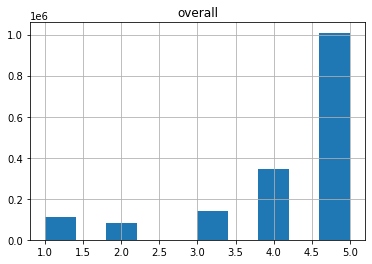

In [ ]:
df_raw_electronics.hist('overall')

In [ ]:
df_raw_electronics['overall'].value_counts()

5.0    1009026
4.0     347041
3.0     142257
1.0     108725
2.0      82139
Name: overall, dtype: int64

It is noticed that the dataset is imbalanced concerning rating scores. As data output balance is key for a better performing algorithm, we will make sure to maintain the data balance while trimming the dataframe.Therefore, we artifically made a balanced dataset through **GetBalancedDataset** function. 


General ideas about **GetBalancedDataset** function: class 0 for those with low rating scores (0.0, 1.0 and 2.0) while class 1 for the counterparts. We picked 150,000 examples for each class from the original dataset by the sequence of reviewTime. 

In [ ]:
def GetBalancedDataset(df, n):
    df.loc[df.overall <= 3, 'overall'] = 0
    df.loc[df.overall > 3, 'overall'] = 1

    index_0 = df.index[df['overall'] == 0].tolist()
    index_1 = df.index[df['overall'] == 1].tolist()

    np.random.seed(42)
    idx_0_out = np.random.choice(index_0, n, replace=False).tolist()
    np.random.seed(42)
    idx_1_out = np.random.choice(index_1, n, replace=False).tolist()

    final_index = idx_0_out + idx_1_out
    balanced_df = df.iloc[final_index, :]
    balanced_df = balanced_df.sort_values(by='unixReviewTime')
    X_out = balanced_df['reviewText']
    Y_out = balanced_df['overall']
    return X_out, Y_out

In [ ]:
x_electronics, y_electronics = GetBalancedDataset(df_raw_electronics, 150000)

In [ ]:
x_electronics.head()

2203    I have found a few places that will do memory ...
2916    If you are looking for the best camcorder in t...
2960    Does not work at all on my brand new PC (98se,...
2324    Unlike many of the other Minidisc owners on he...
2734    I bought a Sony 530 in 08/1999, and have had n...
Name: reviewText, dtype: object

In [ ]:
y_electronics.value_counts()

0.0    150000
1.0    150000
Name: overall, dtype: int64

### **Load from ZIP for movies**

In [ ]:
df_raw_movies = getDF('/content/drive/MyDrive/Colab Notebooks/nlp/reviews_Movies_and_TV_5.json.gz')

In [ ]:
df_raw_movies.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4.0,good version of a classic,1203984000,"02 26, 2008"
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3.0,Good but not as moving,1388361600,"12 30, 2013"
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3.0,Winkler's Performance was ok at best!,1388361600,"12 30, 2013"
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5.0,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008"
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4.0,Best Scrooge yet,1387670400,"12 22, 2013"


In [ ]:
df_raw_movies['reviewText'].head()

0    This is a charming version of the classic Dick...
1    It was good but not as emotionally moving as t...
2    Don't get me wrong, Winkler is a wonderful cha...
3    Henry Winkler is very good in this twist on th...
4    This is one of the best Scrooge movies out.  H...
Name: reviewText, dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf17b76410>]],
      dtype=object)

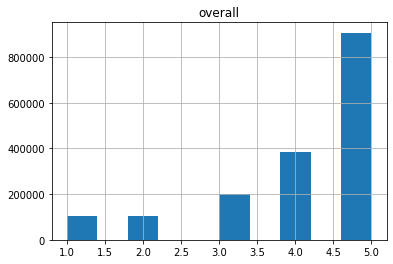

In [ ]:
df_raw_movies.hist('overall')

In [ ]:
df_raw_movies['overall'].value_counts()

5.0    906608
4.0    382994
3.0    201302
1.0    104219
2.0    102410
Name: overall, dtype: int64

In [ ]:
def GetBalancedDataset(df, n):
    df.loc[df.overall <= 3, 'overall'] = 0
    df.loc[df.overall > 3, 'overall'] = 1

    index_0 = df.index[df['overall'] == 0].tolist()
    index_1 = df.index[df['overall'] == 1].tolist()

    np.random.seed(42)
    idx_0_out = np.random.choice(index_0, n, replace=False).tolist()
    np.random.seed(42)
    idx_1_out = np.random.choice(index_1, n, replace=False).tolist()

    final_index = idx_0_out + idx_1_out
    balanced_df = df.iloc[final_index, :]
    balanced_df = balanced_df.sort_values(by='unixReviewTime')
    X_out = balanced_df['reviewText']
    Y_out = balanced_df['overall']
    return X_out, Y_out

In [ ]:
x_movies,y_movies = GetBalancedDataset(df_raw_movies, 150000)

In [ ]:
x_movies.head()

355639    This is so funny.  It has a lot of good jokes ...
403290    This TV animation series opened up many disput...
507970    WRONG TROUSERS has to be one of the most amazi...
300358    Sam Elliott if you are reading- You're the bes...
421645    A new generation has emerged from the ashes of...
Name: reviewText, dtype: object

In [ ]:
y_movies.value_counts()

0.0    150000
1.0    150000
Name: overall, dtype: int64

# Cleaning and preprocessing data

Reference: [data cleaning procedures](https://github.com/JosephAssaker/Twitter-Sentiment-Analysis-Classical-Approach-VS-Deep-Learning/blob/master/Twitter%20Sentiment%20Analysis%20-%20Classical%20Approach%20VS%20Deep%20Learning.ipynb)

In [ ]:
x_data = x_electronics
y_data = y_electronics
csv_path = 'clean_tokens_list_electronics.csv'

### 1. Tokenization

Here we used **word_tokenize** provided by *nltk* library

In [ ]:
x_electronics[2203]

"I have found a few places that will do memory upgrades for all the Palm's. 8M seems to be the max."

In [ ]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize

data = []
X = x_data.tolist()
Y = y_data.tolist()

for x, y in zip(X, Y):
  if y == 1:
    data.append((word_tokenize(x), 1))
  else:
    data.append((word_tokenize(x), 0))
data[:5]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
CPU Time: 247.2458016872406


[(['I',
   'have',
   'found',
   'a',
   'few',
   'places',
   'that',
   'will',
   'do',
   'memory',
   'upgrades',
   'for',
   'all',
   'the',
   'Palm',
   "'s",
   '.',
   '8M',
   'seems',
   'to',
   'be',
   'the',
   'max',
   '.'],
  1),
 (['If',
   'you',
   'are',
   'looking',
   'for',
   'the',
   'best',
   'camcorder',
   'in',
   'the',
   'market',
   ',',
   'stop',
   'looking',
   'this',
   'little',
   'toy',
   'has',
   'it',
   'all',
   '.',
   'The',
   'quality',
   'of',
   'the',
   'picture',
   'and',
   'sound',
   'are',
   'so',
   'great',
   'the',
   'you',
   'will',
   'feel',
   'and',
   'see',
   'every',
   'thing',
   'that',
   'you',
   'filmed',
   'as',
   'if',
   'you',
   'where',
   'there',
   'LIVE',
   'again',
   '.',
   'If',
   'you',
   'have',
   'a',
   'home',
   'theatre',
   'system',
   'with',
   'Adobe',
   'Digital',
   '5.1',
   'you',
   'will',
   'really',
   'see',
   'what',
   'I',
   'mean',
   '.',
   

### 2. Lemmatization 

For example, reducing "builds", "building", or "built" to the lemma "build". In this example, we will use *nltk*'s **WordNetLemmatizer** to accomplish this task. This lemmatizer however takes as input two arguments: a list of tokens to be lemmatized as well as their corresponding part of speech. 

The most common parts of speech in english are nouns and verbs. In order to extract each token's part of speech, we will utilize *nltk*'s **post_tag** function, that takes an input a list of tokens, and returns a list of tuples, where each tuple is composed of a token and its corresponding position tag.

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

# Previewing the pos_tag() output
print(pos_tag(data[0][0]))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[('I', 'PRP'), ('have', 'VBP'), ('found', 'VBN'), ('a', 'DT'), ('few', 'JJ'), ('places', 'NNS'), ('that', 'WDT'), ('will', 'MD'), ('do', 'VB'), ('memory', 'NN'), ('upgrades', 'NNS'), ('for', 'IN'), ('all', 'PDT'), ('the', 'DT'), ('Palm', 'NNP'), ("'s", 'POS'), ('.', '.'), ('8M', 'CD'), ('seems', 'VBZ'), ('to', 'TO'), ('be', 'VB'), ('the', 'DT'), ('max', 'NN'), ('.', '.')]


In [ ]:
data[0][0]

['I',
 'have',
 'found',
 'a',
 'few',
 'places',
 'that',
 'will',
 'do',
 'memory',
 'upgrades',
 'for',
 'all',
 'the',
 'Palm',
 "'s",
 '.',
 '8M',
 'seems',
 'to',
 'be',
 'the',
 'max',
 '.']

In [ ]:
def lemmatize_sentence(tokens):
  lemmatizer = WordNetLemmatizer()
  lemmatized_sentence = []
  for word, tag in pos_tag(tokens):
    # First, we will convert the pos_tag output tags to a tag format that the WordNetLemmatizer can interpret
    # In general, if a tag starts with NN, the word is a noun and if it stars with VB, the word is a verb.
    if tag.startswith('NN'):
      pos = 'n'
    elif tag.startswith('VB'):
      pos = 'v'
    else:
      pos = 'a'
    lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
  return lemmatized_sentence

# Previewing the WordNetLemmatizer() output
print(lemmatize_sentence(data[0][0]))

['I', 'have', 'find', 'a', 'few', 'place', 'that', 'will', 'do', 'memory', 'upgrade', 'for', 'all', 'the', 'Palm', "'s", '.', '8M', 'seem', 'to', 'be', 'the', 'max', '.']


### 3. Remove stop words

Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment. Stop words removing is done by *nltk's* **stopwords** function

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words.
# Including many minimally present cases would negatively impact the performance. 
def cleaned(token):
  if token == 'u':
    return 'you'
  if token == 'r':
    return 'are'
  if token == 'some1':
    return 'someone'
  if token == 'yrs':
    return 'years'
  if token == 'hrs':
    return 'hours'
  if token == 'mins':
    return 'minutes'
  if token == 'secs':
    return 'seconds'
  if token == 'pls' or token == 'plz':
    return 'please'
  if token == '2morow':
    return 'tomorrow'
  if token == '2day':
    return 'today'
  if token == '4got' or token == '4gotten':
    return 'forget'
  if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
    return ''
  return token

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### This step will be our all-in-one noise removal one and produce a csv file with clean data

In [ ]:
# This function will be our all-in-one noise removal function
import re, string
def remove_noise(tokens):
  cleaned_tokens = []
  for token, tag in pos_tag(tokens):
    # Eliminating the token if it is a link
    token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
    # Eliminating the token if it is a mention
    token = re.sub("(@[A-Za-z0-9_]+)","", token)

    if tag.startswith("NN"):
      pos = 'n'
    elif tag.startswith('VB'):
      pos = 'v'
    else:
      pos = 'a'

    lemmatizer = WordNetLemmatizer()
    token = lemmatizer.lemmatize(token, pos)
    cleaned_token = cleaned(token.lower())
        
    # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
    if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
      cleaned_tokens.append(cleaned_token)
            
  return cleaned_tokens
# Prevewing the remove_noise() output
print(remove_noise(data[0][0]))

['find', 'place', 'memory', 'upgrade', 'palm', 'seem', 'max']


In [ ]:
cleaned_tokens_list = []
for tokens, label in data:
  cleaned_tokens_list.append((remove_noise(tokens), label))

In [ ]:
from pandas import DataFrame
dataframe = DataFrame(cleaned_tokens_list,columns=['reviews','scores'])

In [ ]:
dataframe.to_csv(csv_path, index=False)

# Load cleaned training set and testing set from CSV

### **Load from CSV for electronics as our training & validation set**

In this step we load the cleaned electronics reviews, which are saved in csv file from last step. In total, 300,000 data points are loaded and these would be divided into 100 chunks in which each chunk contains 3,000 samples separately.

In [ ]:
df_electronics = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nlp/clean_tokens_list_electronics.csv',converters={'reviews':eval})

In [ ]:
df_electronics.head()

,reviews,scores
0,"[find, place, memory, upgrade, palm, seem, max]",1
1,"[look, best, camcorder, market, stop, look, li...",1
2,"[work, brand, new, 98se, usb, bad, software, s...",0
3,"[unlike, many, minidisc, owner, happen, like, ...",0
4,"[buy, sony, 530, 08/1999, lip-sync, problem, p...",1


In [ ]:
len(df_electronics)

300000

In [ ]:
# df_electronics_sentence = df_electronics

In [ ]:
# df_electronics_sentence['reviews'] = df_electronics_sentence['reviews'].apply(lambda x: ' '.join(x))

In [ ]:
def chunks(array, n, default=0):
  result = []
  for i in range(0, int((len(array)-default)/n)):
    result.append(array[i*n+default: (i+1)*n+default])
  return result

In [ ]:
df_electronics_chunks = chunks(df_electronics, 3000)

In [ ]:
# df_electronics_chunks = chunks(df_electronics_sentence, 3000)

In [ ]:
len(df_electronics_chunks)

100

In [ ]:
df_electronics_chunks[0].head()

,reviews,scores
0,"[find, place, memory, upgrade, palm, seem, max]",1
1,"[look, best, camcorder, market, stop, look, li...",1
2,"[work, brand, new, 98se, usb, bad, software, s...",0
3,"[unlike, many, minidisc, owner, happen, like, ...",0
4,"[buy, sony, 530, 08/1999, lip-sync, problem, p...",1


Below we choose first three chunks for training proposes concerning LSTM and RNN model

In [ ]:
list_electronics_chunks_for_lstm = []
for df_electronics_chunk in df_electronics_chunks:
  list_electronics_chunks_for_lstm.append(df_electronics_chunk.values.tolist())

In [ ]:
print(list_electronics_chunks_for_lstm[0][0])

[['find', 'place', 'memory', 'upgrade', 'palm', 'seem', 'max'], 1]


In [ ]:
len(list_electronics_chunks_for_lstm)

100

In [ ]:
df_training_chunks_for_rnn = pd.concat([df_electronics_chunks[0], df_electronics_chunks[1], df_electronics_chunks[2]])

In [ ]:
df_training_chunks_for_rnn.head()

,reviews,scores
0,"[find, place, memory, upgrade, palm, seem, max]",1
1,"[look, best, camcorder, market, stop, look, li...",1
2,"[work, brand, new, 98se, usb, bad, software, s...",0
3,"[unlike, many, minidisc, owner, happen, like, ...",0
4,"[buy, sony, 530, 08/1999, lip-sync, problem, p...",1


In [ ]:
len(df_training_chunks_for_rnn)

9000

### **Load test data and CD from Movie.csv**

We have already obtained the clean reviewing data for electronics as our training set. **(Size of training set?)** The next step is to introduce concept drift into the dataset of electronics reviews. By applying **introduce_gradual_CD** function we separate 300,000 electronic reviewing examples into 100 chunks, each of which holds 3,000 samples respectively. Then, from chunk[4] to chunk[99], an increasing 1% of data within that chunk is replaced by reviews of movies and TV. The details are shown in the following graphs:

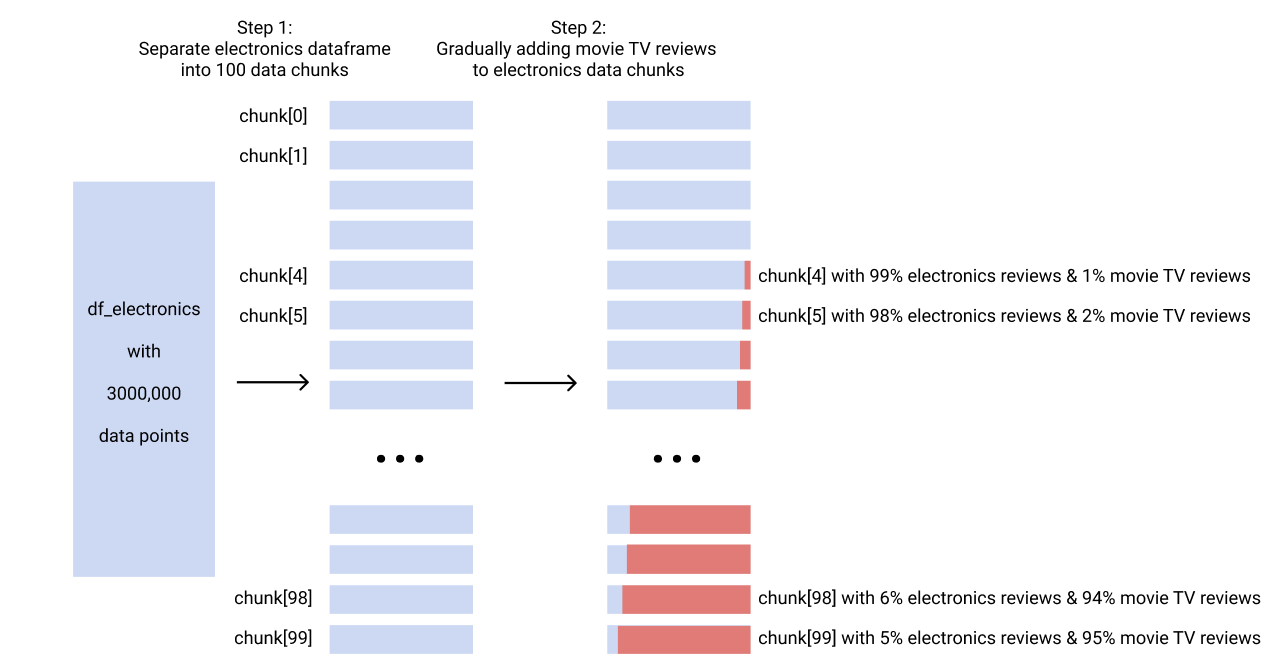

The resulting **test_chunks_X** and **test_chunks_Y** are used for future testing proposes

In [ ]:
df_movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nlp/clean_tokens_list_movies.csv',converters={'reviews':eval})
data_X1 = df_electronics['reviews']
data_Y1 = df_electronics['scores']
data_X2 = df_movies['reviews']
data_Y2 = df_movies['scores']

In [ ]:
def introduce_gradual_CD(data_X_1, data_Y_1, data_X_2, data_Y_2, chunk_size, total_chunk_nr, CD_point, step_size_in_percent):
    result_chunks_X = []
    result_chunks_Y = []
    split_X_1 = chunks(data_X_1, chunk_size)
    split_Y_1 = chunks(data_Y_1, chunk_size)
    split_X_2 = chunks(data_X_2, chunk_size)
    split_Y_2 = chunks(data_Y_2, chunk_size)
    min_chunk_nr = split_X_1.__len__()
    if split_X_1.__len__() > split_X_2.__len__():
        min_chunk_nr = split_X_2.__len__()
    if min_chunk_nr < total_chunk_nr:
        total_chunk_nr = min_chunk_nr
    for index in range(CD_point):
        result_chunks_X.append(split_X_1[index])
        result_chunks_Y.append(split_Y_1[index])
    nr_mix_chunks = int(100/step_size_in_percent)
    if nr_mix_chunks > total_chunk_nr - CD_point:
        nr_mix_chunks = total_chunk_nr - CD_point
    step_size = int(chunk_size*step_size_in_percent*0.01)
    if step_size == 0:
        step_size = 1
    for index_mix in range(0, nr_mix_chunks):
        temp_arr_X_1 = split_X_1[CD_point + index_mix][0:chunk_size-(step_size*(index_mix+1))]
        temp_arr_X_2 = split_X_2[CD_point + index_mix][0:step_size*(index_mix+1)]
        temp_arr_Y_1 = split_Y_1[CD_point + index_mix][0:chunk_size - (step_size * (index_mix+1))]
        temp_arr_Y_2 = split_Y_2[CD_point + index_mix][0:step_size * (index_mix+1)]
        temp_X = np.concatenate((temp_arr_X_1,temp_arr_X_2))
        temp_Y = np.concatenate((temp_arr_Y_1,temp_arr_Y_2))
        result_chunks_X.append(temp_X)
        result_chunks_Y.append(temp_Y)
    for index in range(CD_point+nr_mix_chunks, total_chunk_nr):
        result_chunks_X.append(split_X_2[index])
        result_chunks_Y.append(split_Y_2[index])
    return result_chunks_X, result_chunks_Y

In [ ]:
test_chunks_X, test_chunks_Y = introduce_gradual_CD(data_X1, data_Y1, data_X2, data_Y2, 3000, 100, 5, 1)

### **Check the longest senetence in df_electronics & test chunks**

In [ ]:
text_list = df_electronics['reviews'].tolist()

In [ ]:
text_list[0]

['find', 'place', 'memory', 'upgrade', 'palm', 'seem', 'max']

Check the max number of words in training & validation set

In [ ]:
list_len_training =[]
for text in text_list:
  list_len_training.append(len(text))
max_len_training = max(list_len_training)
print(max_len_training)

3084


Check the max number of words in test set after CD is introduced

In [ ]:
list_len_testing =[]
for i in range(len(test_chunks_X)):
  for text in test_chunks_X[i]:
    list_len_testing.append(len(text))
max_len_testing = max(list_len_testing)
print(max_len_testing)

3316


Distribution of sentence length in test set

In [ ]:
len_frame = pd.DataFrame(list_len_testing)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff958900810>]],
      dtype=object)

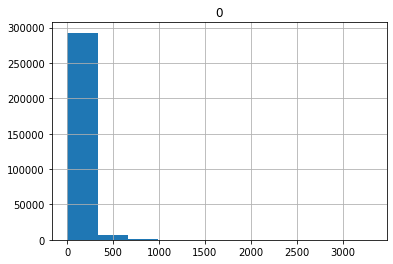

In [ ]:
len_frame.hist()

### **Download GloVe embedding**

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-03-28 12:43:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-28 12:43:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-28 12:43:13--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
def read_glove_vecs(glove_file):
  with open(glove_file, 'r', encoding="utf8") as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      line = line.strip().split()
      curr_word = line[0]
      words.add(curr_word)
      word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
    i = 1
    words_to_index = {}
    index_to_words = {}
    for w in sorted(words):
      words_to_index[w] = i
      index_to_words[i] = w
      i = i + 1
  return words_to_index, index_to_words, word_to_vec_map

Based on GolVe embedding, we get **word_to_index**, **index_to_word** and **word_to_vec_map** as results, which are used to build the embedding layer afterwards

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

# Neural Network Models not saved

### **3. Feedforward Neural Network**

In [ ]:
text_training_nn = df_training_chunks_for_rnn['reviews'].apply(lambda x: ' '.join(x))

In [ ]:
text_training_nn.shape

(9000,)

In [ ]:
xtrain_nn, xvalid_nn, ytrain_nn, yvalid_nn = train_test_split(text_training_nn, df_training_chunks_for_rnn['scores'], stratify=df_training_chunks_for_rnn['scores'], random_state=42, test_size=0.2, shuffle=True)

In [ ]:
len(yvalid_nn)

1800

In [ ]:
len(xtrain_nn)

7200

In [ ]:
model_nn = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model_nn, input_shape=[], dtype = tf.string, trainable = True)
hub_layer(xtrain_nn[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.39501348, -0.1887452 ,  0.01608195,  0.16857252, -0.25534695,
         0.08073437, -0.11308508,  0.14008406, -0.17431086,  0.2564414 ,
         0.32800508,  0.2647357 ,  0.2955985 , -0.12534952, -0.21130243,
        -0.24493882,  0.03405564, -0.18104555,  0.20670691, -0.34726277,
        -0.33953536,  0.17488402, -0.02653525,  0.07271501, -0.0323994 ,
        -0.10114288, -0.13806824, -0.05545229,  0.06217802, -0.01924447,
        -0.12873837, -0.02770301,  0.42466408, -0.13445476,  0.06469391,
        -0.07313751,  0.00391722, -0.13676648,  0.12519011,  0.01620695,
         0.12745593,  0.16867533,  0.46641392,  0.3119348 , -0.03602339,
        -0.08614073, -0.15068887, -0.09819271,  0.6979526 ,  0.2465524 ],
       [ 0.57257664, -0.5219773 , -0.1147684 ,  0.10092758, -0.8662791 ,
        -0.08912381,  0.5135646 ,  0.15761536, -0.65842474,  0.39621702,
        -0.13346267,  0.29343277,  0.22885618, -0.09994926, -0.5606873 ,
 

In [ ]:
model_nn = tf.keras.Sequential()
model_nn.add(hub_layer)
model_nn.add(tf.keras.layers.Dropout(0.3))
model_nn.add(tf.keras.layers.Dense(8, activation = 'sigmoid'))
model_nn.add(tf.keras.layers.Dense(1))
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 48,191,017
Trainable params: 48,191,017
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_nn.compile(optimizer = 'adam', loss = tf.losses.BinaryCrossentropy(from_logits = True), metrics = [tf.metrics.BinaryAccuracy(threshold = 0.0, name = 'accuracy')])

In [ ]:
history = model_nn.fit(xtrain_nn, ytrain_nn, epochs=10, batch_size=128, validation_data=(xvalid_nn, yvalid_nn), verbose=1)

Epoch 1/10
57/57 [==============================] - 5s 36ms/step - loss: 0.7199 - accuracy: 0.5793 - val_loss: 0.6499 - val_accuracy: 0.6156
Epoch 2/10
57/57 [==============================] - 2s 32ms/step - loss: 0.6393 - accuracy: 0.6222 - val_loss: 0.5991 - val_accuracy: 0.6672
Epoch 3/10
57/57 [==============================] - 2s 33ms/step - loss: 0.5759 - accuracy: 0.6832 - val_loss: 0.5447 - val_accuracy: 0.7372
Epoch 4/10
57/57 [==============================] - 2s 33ms/step - loss: 0.5002 - accuracy: 0.7821 - val_loss: 0.5002 - val_accuracy: 0.7728
Epoch 5/10
57/57 [==============================] - 2s 32ms/step - loss: 0.4355 - accuracy: 0.8340 - val_loss: 0.4703 - val_accuracy: 0.7878
Epoch 6/10
57/57 [==============================] - 2s 32ms/step - loss: 0.3764 - accuracy: 0.8712 - val_loss: 0.4536 - val_accuracy: 0.8011
Epoch 7/10
57/57 [==============================] - 2s 33ms/step - loss: 0.3298 - accuracy: 0.8931 - val_loss: 0.4437 - val_accuracy: 0.8033
Epoch 8/10
57

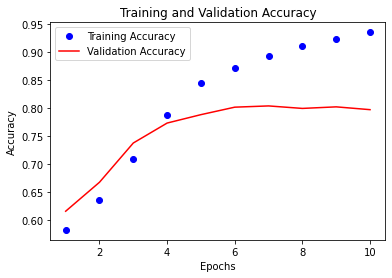

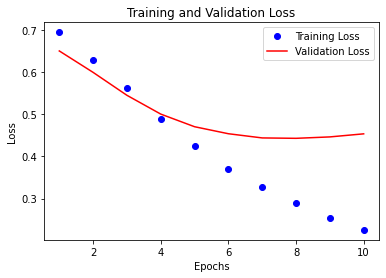

In [ ]:
plot_acc_loss(model_nn.history)

### **4. BERT**

In [ ]:
!pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 8.5MB/s 


In [ ]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.1MB 9.7MB/s 
     |████████████████████████████████| 174kB 34.2MB/s 
     |████████████████████████████████| 102kB 11.0MB/s 
     |████████████████████████████████| 37.6MB 1.3MB/s 
     |████████████████████████████████| 1.2MB 33.6MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 358kB 51.7MB/s 
     |████████████████████████████████| 645kB 54.2MB/s 
     |████████████████████████████████| 706kB 53.5MB/s 


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
training_bert_x = df_electronics['reviews'].apply(lambda x: ' '.join(x))

In [ ]:
chunks_training_bert_x = chunks(training_bert_x, 3000)
chunks_training_bert_y = chunks(df_electronics['scores'], 3000)

In [ ]:
# choose the first three chunks for training (7200 for training, 1800 for validation)
# x_train = pd.concat([chunks_training_bert_x[0], chunks_training_bert_x[1], chunks_training_bert_x[2]], ignore_index=True)
# y_train = pd.concat([chunks_training_bert_y[0], chunks_training_bert_y[1], chunks_training_bert_y[2]], ignore_index=True)

In [ ]:
# choose only the fisrst chunks for trainging (2400 for training, 600 for validation)
x_train = chunks_training_bert_x[0]
y_train = chunks_training_bert_y[0]

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values))

In [ ]:
for feat, targ in dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: b'find place memory upgrade palm seem max', Target: 1
Features: b'look best camcorder market stop look little toy quality picture sound great feel see every thing film live home theatre system adobe digital 5.1 really see mean side need battery last long make sure get tape', Target: 1
Features: b"work brand new 98se usb bad software support helpless ... advertised audible format actually support 'yet say ... n't buy ... rush though late buggy product ...", Target: 0
Features: b"unlike many minidisc owner happen like mp3 minidisks great ... .but something small light tuck pocket nothing beat rio least half size third weight minidisk player yes size make difference many people.i love get free mp3 web *could* put minidisks like able every day put completely different assortment song rio listen certainly much hard record disk one people listen favorite song little repetition n't bother any.unfortunately rio without fault fact hard time recommend meg definitely enough get flash ca

In [ ]:
len(dataset)

3000

In [ ]:
batch_size_bert = 32

In [ ]:
raw_train_ds = dataset.batch(batch_size_bert)

In [ ]:
list(raw_train_ds.as_numpy_iterator())

[(array([b'find place memory upgrade palm seem max',
         b'look best camcorder market stop look little toy quality picture sound great feel see every thing film live home theatre system adobe digital 5.1 really see mean side need battery last long make sure get tape',
         b"work brand new 98se usb bad software support helpless ... advertised audible format actually support 'yet say ... n't buy ... rush though late buggy product ...",
         b"unlike many minidisc owner happen like mp3 minidisks great ... .but something small light tuck pocket nothing beat rio least half size third weight minidisk player yes size make difference many people.i love get free mp3 web *could* put minidisks like able every day put completely different assortment song rio listen certainly much hard record disk one people listen favorite song little repetition n't bother any.unfortunately rio without fault fact hard time recommend meg definitely enough get flash card start vary problem first memory

In [ ]:
import math
train_ds = raw_train_ds.take(math.ceil(float(len(dataset)/batch_size_bert)*0.8))
val_ds = raw_train_ds.skip(math.ceil(float(len(dataset)/batch_size_bert)*0.8))
val_ds = val_ds.take(math.floor(float(len(dataset)/batch_size_bert)*0.2))

In [ ]:
list(val_ds.as_numpy_iterator())

[(array([b'works fine except ... use hotkeys switch workstation scroll lock twice must use front console input also front console input dont work wireless keyboard/mouse combo',
         b"never use fan apc power product let remote past poor performance couple data center work however come time purchase ups home equipment hard ignore price availability apc unit.i buy second one network expand although live nice power-safe neighborhood sometimes get power sag hear unit click server machine never notice thing point.this unit also nice eight plug merely surge protect sense waste battery life server monitor printer fit-and-finish nice replacement battery widely available n't need one yet .so 've reform view apc strongly recommend unit",
         b"buy first come review epinions amazon anywhere else could find take plunge read review d-ne300 use d-nf400 buy daughter d-ne500 epinions amazon amaze wrong comment folk make assume n't sit read manual.it parametric equalizer four setting soft act

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(32):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(label)

Review: b'find place memory upgrade palm seem max'
1
Review: b'look best camcorder market stop look little toy quality picture sound great feel see every thing film live home theatre system adobe digital 5.1 really see mean side need battery last long make sure get tape'
1
Review: b"work brand new 98se usb bad software support helpless ... advertised audible format actually support 'yet say ... n't buy ... rush though late buggy product ..."
0
Review: b"unlike many minidisc owner happen like mp3 minidisks great ... .but something small light tuck pocket nothing beat rio least half size third weight minidisk player yes size make difference many people.i love get free mp3 web *could* put minidisks like able every day put completely different assortment song rio listen certainly much hard record disk one people listen favorite song little repetition n't bother any.unfortunately rio without fault fact hard time recommend meg definitely enough get flash card start vary problem first memory 

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


The plain reviewing texts were added to preprocessing step, after which the plain text inputs are transformed into the format of int32 Tensors. 

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing mouse!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 8000  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


The int 32 tensors was further expected by encoder API for its pooled and senquence outputs. 

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.89206284 -0.34498328 -0.54274094  0.6097522   0.30659077 -0.09689589
  0.88876355  0.21544072 -0.590892   -0.9999564  -0.12379532  0.7630214 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.05311574  0.34468642 -0.06221398 ... -0.31814212  0.41156238
   0.36495999]
 [-0.52889353  0.45654514 -0.44044197 ... -1.0405728   1.3776792
   0.38731903]
 [ 0.23172171  0.19649722 -0.06510463 ... -0.65410775  0.5075355
   0.4695477 ]
 ...
 [ 0.24128422 -0.02912348  0.3782276  ...  0.1741888   0.14311153
  -0.30881172]
 [-0.0969712  -0.31346196  0.1565556  ...  0.27706522  0.21286911
  -0.5187841 ]
 [ 0.29684272  0.0631728   0.44773713 ...  0.13402367  0.13912094
  -0.20103118]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.90656155]], shape=(1, 1), dtype=float32)


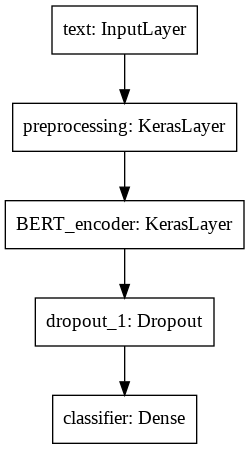

In [ ]:
tf.keras.utils.plot_model(classifier_model)

Loss function and metrices were determined to be binary cross entropy and binary accuracy respectively.

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

These are hyper parameters to be adjusted (**how???**)

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps, optimizer_type='adamw')

In [ ]:
steps_per_epoch

75

In [ ]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds, validation_data=val_ds, epochs=5)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/5
75/75 [==============================] - 88s 968ms/step - loss: 0.8462 - binary_accuracy: 0.5382 - val_loss: 0.5180 - val_binary_accuracy: 0.7448
Epoch 2/5
75/75 [==============================] - 73s 976ms/step - loss: 0.5336 - binary_accuracy: 0.7236 - val_loss: 0.4904 - val_binary_accuracy: 0.7865
Epoch 3/5
75/75 [==============================] - 73s 976ms/step - loss: 0.3960 - binary_accuracy: 0.8284 - val_loss: 0.5272 - val_binary_accuracy: 0.7795
Epoch 4/5
75/75 [==============================] - 73s 976ms/step - loss: 0.2775 - binary_accuracy: 0.9034 - val_loss: 0.6590 - val_binary_accuracy: 0.7917
Epoch 5/5
75/75 [==============================] - 73s 974ms/step - loss: 0.2092 - binary_accuracy: 0.9314 - val_loss: 0.6687 - val_binary_accuracy: 0.7830


# Already saved Neural Neworks Models

### **1. LSTM with GloVe**

In [ ]:
unks = []
UNKS = []

def cleared(word):
  res = ""
  prev = None
  for char in word:
    if char == prev: continue
    prev = char
    res += char
  return res

In [ ]:
def sentence_to_indices(sentence_words, word_to_index, i):
  global X, Y
  sentence_indices = []
  for j, w in enumerate(sentence_words):
    try:
      index = word_to_index[w]
    except:
      UNKS.append(w)
      w = cleared(w)
      try:
        index = word_to_index[w]
      except:
        index = word_to_index['unk']
        unks.append(w)
    X[i, j] = index

In [ ]:
word_to_vec_map['find']

In [ ]:
word_to_index['find']

In [ ]:
word_to_index['place']

In [ ]:
cleaned_tokens_list = list_electronics_chunks_for_lstm[0] + list_electronics_chunks_for_lstm[1] + list_electronics_chunks_for_lstm[2]

list_len = [len(i) for i, j in cleaned_tokens_list]
max_len_trainingset = max(list_len)
max_len_trainingset = 1175
print('max_len:', max_len_trainingset)

X = np.zeros((len(cleaned_tokens_list), max_len_trainingset))
Y = np.zeros((len(cleaned_tokens_list), ))

for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens,word_to_index,i)
    Y[i] = label
print(X[:5])
print(Y[:5])

In [ ]:
X.shape

In [ ]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0] #50
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=True, input_shape=(max_len,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [ ]:
model_lstm = Sequential()
model_lstm.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, 1175))
model_lstm.add(Dropout(rate=0.2))
model_lstm.add(Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2,activation='softsign',return_sequences=True)))
model_lstm.add(Dropout(rate=0.2))
model_lstm.add(Bidirectional(LSTM(units=64, dropout=0.2,recurrent_dropout=0.2,activation='softsign',return_sequences=False)))
model_lstm.add(Dense(units=1, activation='sigmoid'))
model_lstm.summary()

In [ ]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X[0]

In [ ]:
x_train_lstm, x_valid_lstm, y_train_lstm, y_valid_lstm = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [ ]:
x_train_lstm

In [ ]:
len(x_train_lstm)

In [ ]:
y_train_lstm

In [ ]:
model_lstm.fit(x_train_lstm, y_train_lstm, validation_data=(x_valid_lstm, y_valid_lstm), epochs = 20, batch_size = 128, shuffle=True)

In [ ]:
plot_acc_loss(model_lstm.history)

### **2. Simple RNN without word embedding**

In [ ]:
xtrain_rnn, xvalid_rnn, ytrain_rnn, yvalid_rnn = train_test_split(df_training_chunks_for_rnn['reviews'], df_training_chunks_for_rnn['scores'], stratify=df_training_chunks_for_rnn['scores'], random_state=42, test_size=0.2, shuffle=True)

In [ ]:
# using keras tokenizer here
from keras.preprocessing import text
token = text.Tokenizer(num_words=None)
max_len_rnn = 1175

token.fit_on_texts(list(xtrain_rnn) + list(xvalid_rnn))
xtrain_seq = token.texts_to_sequences(xtrain_rnn)
xvalid_seq = token.texts_to_sequences(xvalid_rnn)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len_rnn)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len_rnn)

word_index = token.word_index

In [ ]:
model_rnn = Sequential()
model_rnn.add(Embedding(len(word_index) + 1, 300, input_length=max_len_rnn))
model_rnn.add(Dropout(rate=0.3))
model_rnn.add(SimpleRNN(100))  
model_rnn.add(Dense(1,activation = 'sigmoid'))
model_rnn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_rnn.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1175, 300)         15232200  
_________________________________________________________________
dropout_28 (Dropout)         (None, 1175, 300)         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               40100     
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 101       
Total params: 15,272,401
Trainable params: 15,272,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_rnn.fit(xtrain_pad, ytrain_rnn, validation_data=(xvalid_pad, yvalid_rnn), epochs = 5, batch_size = 128, shuffle=True)

Epoch 1/5
57/57 [==============================] - 57s 994ms/step - loss: 0.6814 - accuracy: 0.5696 - val_loss: 0.6205 - val_accuracy: 0.6450
Epoch 2/5
57/57 [==============================] - 59s 1s/step - loss: 0.3737 - accuracy: 0.8792 - val_loss: 0.6300 - val_accuracy: 0.7339
Epoch 3/5
57/57 [==============================] - 59s 1s/step - loss: 0.0570 - accuracy: 0.9871 - val_loss: 0.8371 - val_accuracy: 0.6639
Epoch 4/5
57/57 [==============================] - 57s 1s/step - loss: 0.0119 - accuracy: 0.9987 - val_loss: 0.8138 - val_accuracy: 0.7078
Epoch 5/5
57/57 [==============================] - 57s 997ms/step - loss: 0.0036 - accuracy: 0.9996 - val_loss: 0.9015 - val_accuracy: 0.6878


# Testing and saving (Not used anymore)

### **Result testing for LSTM**

In [ ]:
def test_acc_plot(accuracy_list):
  chunk_nr = np.arange(97).tolist()
  plt.plot(chunk_nr, accuracy_list, marker='o')
  plt.title("Accuracy of LSTM with time",fontsize=14)
  plt.xlabel('Chunk number', fontsize= 14)
  plt.ylabel('Accuracy', fontsize =14)
  plt.grid(True)
  plt.show()

In [ ]:
def sentence_to_indices_test(sentence_words, word_to_index, max_len):
  sentence_index = np.zeros(max_len)
  for j, w in enumerate(sentence_words):
    try:
      index = word_to_index[w]
    except:
      UNKS.append(w)
      w = cleared(w)
      try:
        index = word_to_index[w]
      except:
        index = word_to_index['unk']
        unks.append(w)
    sentence_index[j] = index
  return sentence_index

In [ ]:
def lstm_test(test_chunk_X,test_chunk_Y):
  test_lists = list(zip(test_chunk_X,test_chunk_Y))
  test_lists_len = len(test_lists)
  
  list_len =[]
  for text in test_chunks_X[99]:
    list_len.append(len(text))
  max_len = max(list_len)
  max_len=3316

  X_test = np.zeros((test_lists_len, max_len))
  Y_test = np.zeros((test_lists_len, ))
  results_list = []
  for i, tk_lb in enumerate(test_lists):
    tokens, label = tk_lb
    X_test[i] = sentence_to_indices_test(tokens, word_to_index, max_len)
    Y_test[i] = label
  results_list.append(model_lstm.predict(X_test))
  
  acc = model_lstm.evaluate(X_test, Y_test)
  return acc[1], results_list

In [ ]:
accuracy, results_list = lstm_test(test_chunks_X[90],test_chunks_Y[90])

94/94 [==============================] - 22s 220ms/step - loss: 0.6799 - accuracy: 0.6840


In [ ]:
results_list

[array([[0.8742047 ],
        [0.69432324],
        [0.43888104],
        ...,
        [0.88118917],
        [0.02144932],
        [0.5135117 ]], dtype=float32)]

In [ ]:
accuracy_all =[]
results_all =[]
for i in range(3,100):
  accuracy, results_list = lstm_test(test_chunks_X[i],test_chunks_Y[i])
  accuracy_all.append(accuracy)
  results_all.append(results_list)
test_acc_plot(accuracy_list)

94/94 [==============================] - 13s 136ms/step - loss: 0.6514 - accuracy: 0.5893


KeyboardInterrupt: ignored

### **Save the LSTM model**

In [ ]:
model_lstm.save('electronics_lstm_with_glove_model.h5')

### **Result testing for simple RNN**

In [ ]:
def rnn_test(test_chunk_X, test_chunk_Y):
  results_list =[]
  token.fit_on_texts(list(test_chunk_X)))
  xtest_seq = token.texts_to_sequences(test_chunk_X)
  xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=1175)
  results_list.append(model_rnn.predict(xtest_pad))
  
  acc = model_rnn.evaluate(xtest_pad, test_chunk_Y)
  return acc[1], results_list

In [ ]:
accuracy, results_list_rnn = rnn_test(test_chunks_X[99], test_chunks_Y[99])

94/94 [==============================] - 9s 93ms/step - loss: 1.0324 - accuracy: 0.6700


In [ ]:
results_list_rnn

[array([[0.9473074 ],
        [0.9568096 ],
        [0.97641444],
        ...,
        [0.7674546 ],
        [0.15333652],
        [0.59528685]], dtype=float32)]

In [ ]:
accuracy_all_rnn =[]
results_all_rnn =[]
for i in range(3,100):
  accuracy, results_list = rnn_test(test_chunks_X[i],test_chunks_Y[i])
  accuracy_all_rnn.append(accuracy)
  results_all_rnn.append(results_list)
test_acc_plot(accuracy_list)

94/94 [==============================] - 18s 188ms/step - loss: 0.9119 - accuracy: 0.5910


KeyboardInterrupt: ignored

### **Save RNN model**

In [ ]:
model_rnn.save('electronics_rnn_model.h5')

### **Result tesing NN**

In [ ]:
def nn_test(test_chunk_X,test_chunk_Y):
  sentence = pd.Series(test_chunk_X).apply(lambda x: ' '.join(x))
  results_list = model_nn.predict(sentence)
  acc = model_nn.evaluate(sentence, test_chunk_Y)
  return acc[1], results_list

In [ ]:
accuracy_nn, results_list_nn = nn_test(test_chunks_X[99],test_chunks_Y[99])

94/94 [==============================] - 0s 3ms/step - loss: 0.5595 - accuracy: 0.7183


In [ ]:
results_list_nn

array([[ 1.2826751 ],
       [ 1.7280107 ],
       [ 0.4086114 ],
       ...,
       [-0.22466928],
       [-1.1542584 ],
       [-0.6665119 ]], dtype=float32)

### **Result tesing BERT**

In [ ]:
def bert_test(test_chunk_X, test_chunk_Y):
  x_chunk = pd.Series(test_chunk_X)
  y_chunk = pd.Series(test_chunk_Y)
  x_chunk = x_chunk.apply(lambda x: ' '.join(x))
  results_list = classifier_model.predict(x_chunk)
  results_bert = []
  for i in range(len(results_list)):
    results_bert.append(results_list[i][0])
  results_bert = np.array(results_bert)
  results_bert[results_bert <= 0] = 0
  results_bert[results_bert > 0] = 1
  results_bert = results_bert.tolist()
  acc = classifier_model.evaluate(x_chunk,y_chunk)
  return acc[1], results_bert

In [ ]:
accuracy_bert, results_list_bert = bert_test(test_chunks_X[3],test_chunks_Y[3])

94/94 [==============================] - 11s 115ms/step - loss: 0.5168 - binary_accuracy: 0.7870


### **GRU with GloVe**

In [ ]:
# GRU with Glove embeddings and two dense layers
model_gru = Sequential()
model_gru.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, 1175))
model_gru.add(GRU(400))
model_gru.add(Dense(1, activation = 'sigmoid'))
model_gru.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_gru.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1175, 50)          20000050  
_________________________________________________________________
gru (GRU)                    (None, 400)               542400    
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 401       
Total params: 20,542,851
Trainable params: 20,542,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

In [ ]:
len(X_train)

7200

In [ ]:
len(Y_train)

7200

In [ ]:
model_gru.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 10, batch_size = 128, shuffle=True)

Epoch 1/10
57/57 [==============================] - 26s 415ms/step - loss: 0.6862 - accuracy: 0.5721 - val_loss: 0.6829 - val_accuracy: 0.5722
Epoch 2/10
57/57 [==============================] - 23s 411ms/step - loss: 0.6833 - accuracy: 0.5712 - val_loss: 0.6827 - val_accuracy: 0.5722
Epoch 3/10
 8/57 [===>..........................] - ETA: 19s - loss: 0.6817 - accuracy: 0.5756

KeyboardInterrupt: ignored

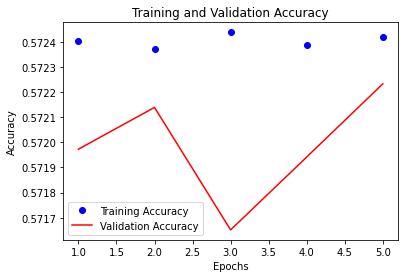

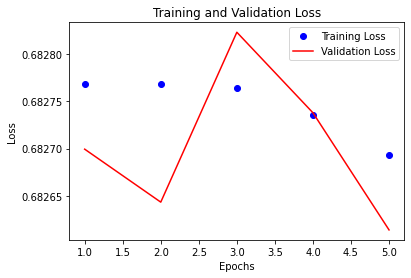

In [ ]:
plot_acc_loss(model_gru.history)



---------------------


# 1. Import

In [ ]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from nltk import classify
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from nltk import NaiveBayesClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.preprocessing import text

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
import pickle

# Calculate contribution

Reference: E. Fersini ⁎, E. Messina, F.A. Pozzi. Sentiment analysis: Bayesian Ensemble Learning

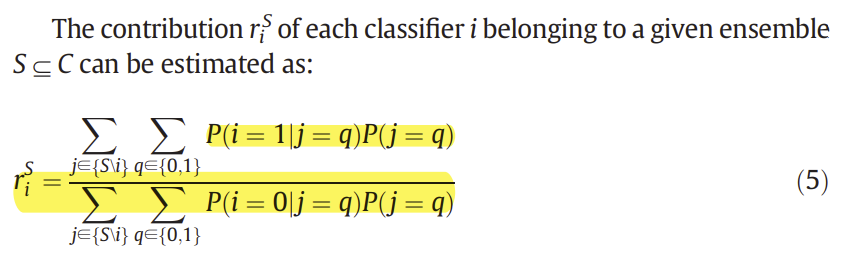

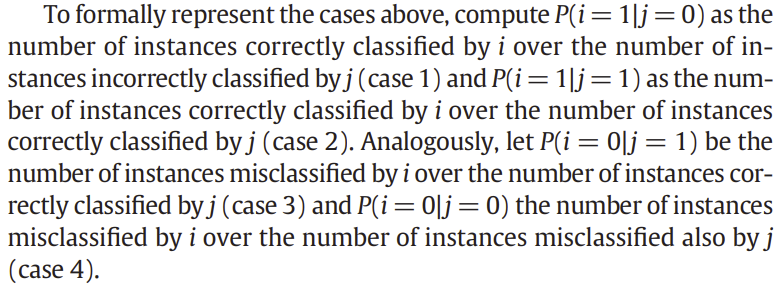

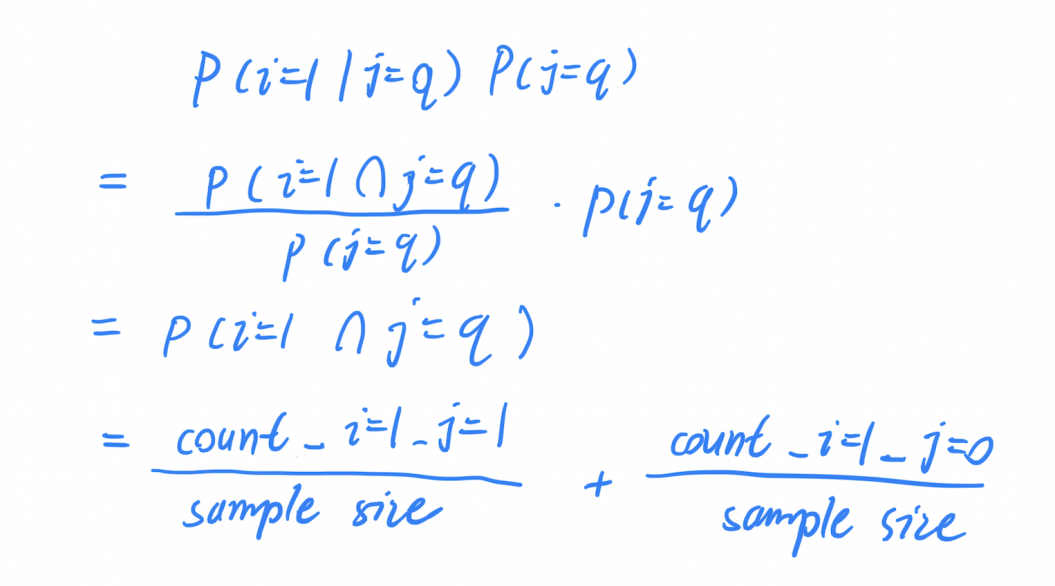

In [ ]:
from scipy.special import comb
def contribution_i(all_pred_list, i_index, correct_labels_list):
  count_ipos_jneg = 0
  count_ineg_jneg = 0
  count_ipos_jpos = 0
  count_ineg_jpos = 0
  for i in range(len(all_pred_list[i_index])):
    for j_index in range(len(all_pred_list)):
      if j_index == i_index:
          continue

      if all_pred_list[j_index][i] == correct_labels_list[i]:
        if all_pred_list[i_index][i] == correct_labels_list[i]:
          count_ipos_jpos+=1
        else:
          count_ineg_jpos+=2
      else:
        if all_pred_list[i_index][i] == correct_labels_list[i]:
          count_ipos_jneg+=2
        else:
          count_ineg_jneg+=1
  contribution_for_i = float((count_ipos_jpos + count_ipos_jneg)/(count_ineg_jpos + count_ineg_jneg))
  return contribution_for_i

def contribution_all(all_pred_list, correct_labels_list):
    contribution_list = []
    for index in range(len(all_pred_list)):
        temp = contribution_i(all_pred_list, index, correct_labels_list)
        contribution_list.append(temp)
    return contribution_list

def get_contributions(prediction_function_list, model_list, X_chunk, Y_chunk, vectorizer_list):
    all_pre_list = []
    for index in range(len(prediction_function_list)):
        temp_pre, temp_acc = prediction_function_list[index](model_list[index], X_chunk, Y_chunk, vectorizer_list[index])
        all_pre_list.append(temp_pre)

    contribution_list = contribution_all(all_pre_list, Y_chunk)
    ACC = sum(contribution_list)/len(contribution_list)
    print("Contribution list:", contribution_list)
    print("ACC:", ACC)

def find_max_diversity_with_DS(selected_index_list, candidate_index_list, all_pre_list, X_chunk, Y_chunk):
    # all_pre_list = []
    # for index in range(len(prediction_function_list)):
    #     temp_pre, temp_acc = prediction_function_list[index](model_list[index], X_chunk, Y_chunk, vectorizer_list[index])
    #     all_pre_list.append(temp_pre)
    max_diversity = 0
    max_index = 0
    for index in range(len(candidate_index_list)):
      temp_index_list = selected_index_list[:]
      temp_index_list.append(candidate_index_list[index])
      temp_diversity_sum = 0
      count = 0
      for i in range(len(temp_index_list)-1):
        for j in range(len(temp_index_list)-i-1):
          temp_diversity_sum += DS_pair_diversity(all_pre_list[temp_index_list[i]],all_pre_list[temp_index_list[i+j+1]])
          count += 1
          # print(temp_index_list[i],temp_index_list[i+j+1])
      # print("count", count)
      # print("verify", comb(len(temp_index_list),2))
      average_diversity = temp_diversity_sum/comb(len(temp_index_list),2)
      print(candidate_index_list[index], average_diversity)
      if average_diversity > max_diversity:
        max_diversity = average_diversity
        max_index = candidate_index_list[index]
    print("final")
    print(max_diversity, max_index)
    return max_diversity, max_index

def find_max_diversity_with_Q(selected_index_list, candidate_index_list,all_pre_list, X_chunk, Y_chunk):
    # all_pre_list = []
    # for index in range(len(prediction_function_list)):
    #     temp_pre, temp_acc = prediction_function_list[index](model_list[index], X_chunk, Y_chunk, vectorizer_list[index])
    #     all_pre_list.append(temp_pre)
    min_similarity = 1
    min_index = 0
    for index in range(len(candidate_index_list)):
      temp_index_list = selected_index_list[:]
      temp_index_list.append(candidate_index_list[index])
      temp_similarity_sum = 0
      count = 0
      for i in range(len(temp_index_list)-1):
        for j in range(len(temp_index_list)-i-1):
          temp_similarity_sum += Q_pair_similarity(all_pre_list[temp_index_list[i]],all_pre_list[temp_index_list[i+j+1]])
          # count += 1
          # print(temp_index_list[i],temp_index_list[i+j+1])
      # print("count", count)
      # print("verify", comb(len(temp_index_list),2))
      average_similarity = temp_similarity_sum/comb(len(temp_index_list),2)
      print(candidate_index_list[index], average_similarity)
      if average_similarity < min_similarity:
        min_similarity = average_similarity
        min_index = candidate_index_list[index]
    print("final")
    print(min_similarity, min_index)
    return min_similarity, min_index

def find_max_diversity_with_DF(selected_index_list, candidate_index_list, all_pre_list, X_chunk, Y_chunk):
    # all_pre_list = []
    # for index in range(len(prediction_function_list)):
    #     temp_pre, temp_acc = prediction_function_list[index](model_list[index], X_chunk, Y_chunk, vectorizer_list[index])
    #     all_pre_list.append(temp_pre)
    min_similarity = 1
    min_index = 0
    for index in range(len(candidate_index_list)):
      temp_index_list = selected_index_list[:]
      temp_index_list.append(candidate_index_list[index])
      temp_similarity_sum = 0
      count = 0
      for i in range(len(temp_index_list)-1):
        for j in range(len(temp_index_list)-i-1):
          temp_similarity_sum += DF_pair_similarity(all_pre_list[temp_index_list[i]],all_pre_list[temp_index_list[i+j+1]], Y_chunk)
          # count += 1
          # print(temp_index_list[i],temp_index_list[i+j+1])
      # print("count", count)
      # print("verify", comb(len(temp_index_list),2))
      average_similarity = temp_similarity_sum/comb(len(temp_index_list),2)
      print(candidate_index_list[index], average_similarity)
      if average_similarity < min_similarity:
        min_similarity = average_similarity
        min_index = candidate_index_list[index]
    print("final")
    print(min_similarity, min_index)
    return min_similarity, min_index


def find_min_diversity_with_DF_back(selected_index_list, candidate_index_list, all_pre_list, X_chunk, Y_chunk):
    # all_pre_list = []
    # for index in range(len(prediction_function_list)):
    #     temp_pre, temp_acc = prediction_function_list[index](model_list[index], X_chunk, Y_chunk, vectorizer_list[index])
    #     all_pre_list.append(temp_pre)
    min_similarity = 1
    min_index = 0
    for index in range(len(selected_index_list)):
      temp_index_list = selected_index_list[:]
      temp_index_list.pop(index)
      temp_similarity_sum = 0
      count = 0
      for i in range(len(temp_index_list)-1):
        for j in range(len(temp_index_list)-i-1):
          temp_similarity_sum += DF_pair_similarity(all_pre_list[temp_index_list[i]],all_pre_list[temp_index_list[i+j+1]], Y_chunk)
          # count += 1
          # print(temp_index_list[i],temp_index_list[i+j+1])
      # print("count", count)
      # print("verify", comb(len(temp_index_list),2))
      average_similarity = temp_similarity_sum/comb(len(temp_index_list),2)
      print(selected_index_list[index], average_similarity)
      if average_similarity < min_similarity:
        min_similarity = average_similarity
        min_index = selected_index_list[index]
    print("final")
    print(min_similarity, min_index)
    return min_similarity, min_index


def DS_pair_diversity(prediction_list_A, prediction_list_B):
    unmatch_count = 0
    for index in range(len(prediction_list_A)):
      if prediction_list_A[index] != prediction_list_B[index]:
        unmatch_count += 1
    disagreement = unmatch_count / len(prediction_list_A)
    return disagreement

def Q_pair_similarity(prediction_list_A, prediction_list_B):
    A_P_B_N = 0
    A_P_B_P = 0
    A_N_B_P = 0
    A_N_B_N = 0
    for index in range(len(prediction_list_A)):
      if prediction_list_A[index] ==1:
        if prediction_list_B[index] == 1:
          A_P_B_P += 1
        else:
          A_P_B_N += 1
      else:
        if prediction_list_B[index] == 1:
          A_N_B_P += 1
        else:
          A_N_B_N += 1
    Q = (A_P_B_P * A_N_B_N - A_N_B_P * A_P_B_N) / (A_P_B_P * A_N_B_N + A_N_B_P * A_P_B_N)
    return Q

def DF_pair_similarity(prediction_list_A, prediction_list_B, true_label):
  count_00 = 0
  for index in range(len(prediction_list_A)):
    if prediction_list_A[index] != true_label[index] and prediction_list_B[index] != true_label[index]:
      count_00 += 1
  return count_00 / len(prediction_list_A)

# 2. Lexicon based

In [ ]:
# -*- coding: utf-8 -*-
# lbsa.py: lexicon-based sentiment analysis
# author : Antoine Passemiers

import numpy as np
import pandas as pd
import os
import re
import sys
import io
import pickle
import xlrd
import csv
import zipfile
import requests

from urllib.request import urlretrieve

TOKENIZER = re.compile(f'([!"#$%&\'()*+,-./:;<=>?@[\\]^_`|~“”¨«»®´·º½¾¿¡§£₤‘’\n\t])')


class UnknownSource(Exception):

    def __init__(self, *args, **kwargs):
        Exception.__init__(self, *args, **kwargs)


class LexiconException(Exception):

    def __init__(self, *args, **kwargs):
        Exception.__init__(self, *args, **kwargs)


class Lexicon:

    def __init__(self, dataframe, tag_names, source, language='english'):
        self.dataframe = dataframe
        self.tag_names = tag_names
        self.source = source
        self.language = language
        self.table = dict()
        self.set_language(self.table, language)

    def set_language(self, table, language):
        tags = np.asarray(self.dataframe[self.tag_names])
        for key, value in zip(self.dataframe[self.language], tags):
            if value.sum() != 0:
                table[key] = value

    def get(self, token):
        if token.isdigit():
            return None
        return self.table.get(token)

    def get_n_tags(self):
        return len(self.tag_names)

    def get_tag_names(self):
        return self.tag_names

    def process(self, text, as_dict=True):
        tokens = tokenize(text) if not isinstance(text, list) else text
        n_tags = self.get_n_tags()
        counters = np.zeros(n_tags, dtype=np.int)
        for token in tokens:
            value = self.get(token.lower())
            if value is not None:
                counters += value
        if as_dict:
            return {name: counter for name, counter in zip(self.tag_names, counters)}
        else:
            return counters

    def __len__(self):
        return len(self.dataframe)


class FeatureExtractor:

    def __init__(self, *args):
        self.lexicons = list(args)
        self.sizes = [lexicon.get_n_tags() for lexicon in self.lexicons]
        self.offsets = np.cumsum([0] + self.sizes)
        self.n_features = sum(self.sizes)
        self.feature_names = list()
        for lexicon in self.lexicons:
            tag_names = [lexicon.source + '_' + name for name in lexicon.get_tag_names()]
            self.feature_names += tag_names

    def process(self, X):
        if isinstance(X, str):
            X = [X]
        elif len(X) == 0:
            return list()
        features = np.empty((len(X), self.n_features))
        for i, text in enumerate(X):
            tokens = tokenize(text)
            for j, lexicon in enumerate(self.lexicons):
                features[i, self.offsets[j]:self.offsets[j + 1]] = lexicon.process(tokens, as_dict=False)
        return np.squeeze(features)


def make_time_analysis(text, lexicon):
    if isinstance(text, list):
        tokens = text
    else:
        tokens = tokenize(text)
    n_tags = lexicon.get_n_tags()
    tag_names = lexicon.get_tag_names()
    mask = np.zeros((len(tokens), n_tags), dtype=np.int)
    for token_id, token in enumerate(tokens):
        value = lexicon.get(token.lower())
        if value is not None:
            mask[token_id, :] += value
    data = {key: value for key, value in zip(tag_names, mask.T)}
    return data


class DownloadProgressBar:

    def __init__(self, prefix, length=30):
        self.prefix = prefix
        self.length = length
        self.downloaded = 0
        self.total_size = None
        self.update(0)

    def progress_hook(self, count, block_size, total_size):
        self.total_size = total_size
        self.downloaded += block_size
        progress = np.clip(float(self.downloaded) / float(self.total_size), 0., 1.)
        self.update(progress)

    def update(self, progress):
        percent = 100. * progress
        n_blocks = int(np.round(progress * self.length))
        bar = ('=' * n_blocks).ljust(self.length)
        sys.stdout.write('\r%s [%s] %.2f %%\r' % (self.prefix, bar, percent))
        if self.downloaded == self.total_size:
            sys.stdout.write('\n')


def get_cache_dir():
    home = os.path.expanduser("~")
    LBSA_DATA_DIR = os.path.join(home, '.lbsa')
    if not os.path.isdir(LBSA_DATA_DIR):
        os.makedirs(LBSA_DATA_DIR)
    return LBSA_DATA_DIR


def load_nrc_lexicon():
    LBSA_DATA_DIR = get_cache_dir()
    nrc_filename = "NRC-Emotion-Lexicon-v0.92-InManyLanguages-web"

    def download_lexicon():
        LEXICON_URL = "http://www.saifmohammad.com/WebDocs/%s.xlsx" % nrc_filename
        progressbar = DownloadProgressBar('Downloading NRC lexicon')
        urlretrieve(
            LEXICON_URL,
            os.path.join(LBSA_DATA_DIR, "%s.xlsx" % nrc_filename),
            reporthook=progressbar.progress_hook)
        print('')

    if not os.path.exists(os.path.join(LBSA_DATA_DIR, "%s.csv" % nrc_filename)):
        # Download lexicon in XLSX format
        if not os.path.exists(os.path.join(LBSA_DATA_DIR, "%s.xlsx" % nrc_filename)):
            download_lexicon()

        # Convert from XLSX to CSV file
        """
        wb = xlrd.open_workbook(os.path.join(LBSA_DATA_DIR, "%s.xlsx" % nrc_filename))
        sheet = wb.sheet_by_name('NRC-Emotion-Lexicon-v0.92-InMan')
        """
        filepath = os.path.join(LBSA_DATA_DIR, "%s.xlsx" % nrc_filename)
        try:
            wb = xlrd.open_workbook(os.path.join(LBSA_DATA_DIR, "%s.xlsx" % nrc_filename))
        except:
            download_lexicon()
            try:
                wb = xlrd.open_workbook(os.path.join(LBSA_DATA_DIR, "%s.xlsx" % nrc_filename))
            except:
                raise LexiconException('Error: Could not download NRC lexicon.')
        # Convert from XLSX to CSV file
        sheet = wb.sheet_by_name('NRC-Emotion-Lexicon-v0.92-InMan')
        with open(os.path.join(LBSA_DATA_DIR, "%s.csv" % nrc_filename), mode='w', encoding='utf8') as csv_file:
            writer = csv.writer(csv_file, quoting=csv.QUOTE_ALL)
            for rownum in range(sheet.nrows):
                writer.writerow(sheet.row_values(rownum))

        # Remove XLSX file
        os.remove(os.path.join(LBSA_DATA_DIR, "%s.xlsx" % nrc_filename))

    sentiment_names = ["positive", "negative", "anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise",
                       "trust"]
    lexicon_path = os.path.join(__file__, os.path.join(LBSA_DATA_DIR, '%s.csv' % nrc_filename))
    nrc_all_languages = pd.read_csv(lexicon_path, encoding='utf8')
    nrc_all_languages.rename(columns=lambda x: x.replace('Word', '').split('Translation')[0].rstrip(' ').lower(),
                             inplace=True)
    for column_name in sentiment_names:
        nrc_all_languages[column_name] = nrc_all_languages[column_name].astype(np.int32)
    return nrc_all_languages, sentiment_names


"""
def load_bing_opinion_lexicon():
    LBSA_DATA_DIR = get_cache_dir()
    bing_filename = "opinion-lexicon-English"
    if not os.path.isdir(os.path.join(LBSA_DATA_DIR, "bing")):
        os.makedirs(os.path.join(LBSA_DATA_DIR, "bing"))
    if not os.path.exists(os.path.join(LBSA_DATA_DIR, "bing/positive.txt")):
        # Download rar archive
        LEXICON_URL = "http://www.cs.uic.edu/~liub/FBS/%s.rar" % bing_filename
        filepath = os.path.join(LBSA_DATA_DIR, "%s.rar" % bing_filename)
        urlretrieve(LEXICON_URL, filepath)
        rar = rarfile.RarFile(filepath)
        rar.extractall(path=os.path.join(LBSA_DATA_DIR, "bing"))
        # TODO
"""


def load_mpqa_sujectivity_lexicon(name='', organization='', email=''):
    LBSA_DATA_DIR = get_cache_dir()
    if not os.path.isdir(os.path.join(LBSA_DATA_DIR, "mpqa")):
        os.makedirs(os.path.join(LBSA_DATA_DIR, "mpqa"))
    filepath = os.path.join(LBSA_DATA_DIR, 'mpqa/subjectivity_clues_hltemnlp05/subjclueslen1-HLTEMNLP05.tff')
    if not os.path.exists(filepath):
        print('Downloading mpqa lexicon...')
        response = requests.post(
            "http://mpqa.cs.pitt.edu/request_resource.php",
            data={"name": "", "organization": "", "email": "", "dataset": "subj_lexicon"})
        zf = zipfile.ZipFile(io.BytesIO(response.content))
        zf.extractall(path=os.path.join(LBSA_DATA_DIR, "mpqa"))

    with open(filepath) as f:
        words, positive, negative, strong_subj = list(), list(), list(), list()
        for line in f.readlines():
            items = line.rstrip().split(' ')
            if len(items) == 6:
                words.append(items[2].split('=')[1])
                strong_subj.append(1 if (items[0].split('=')[1] == 'strongsubj') else 0)
                positive.append(1 if items[5].split('=')[1] in ['positive', 'both'] else 0)
                negative.append(1 if items[5].split('=')[1] in ['negative', 'both'] else 0)
    return pd.DataFrame({
        'english': words,
        'positive': np.asarray(positive, dtype=np.int),
        'negative': np.asarray(negative, dtype=np.int),
        'strong_subjectivty': np.asarray(strong_subj, dtype=np.int)
    })


def load_afinn_opinion_lexicon():
    LBSA_DATA_DIR = get_cache_dir()
    if not os.path.isdir(os.path.join(LBSA_DATA_DIR, "afinn")):
        os.makedirs(os.path.join(LBSA_DATA_DIR, "afinn"))
    if not os.path.exists(os.path.join(LBSA_DATA_DIR, "afinn/AFINN/AFINN-111.txt")):
        # Download zip archive
        LEXICON_URL = 'http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/6010/zip/imm6010.zip'
        filepath = os.path.join(LBSA_DATA_DIR, "afinn/imm6010.zip")
        progressbar = DownloadProgressBar('Downloading AFINN lexicon')
        urlretrieve(LEXICON_URL, filepath, reporthook=progressbar.progress_hook)
        print('')
        with zipfile.ZipFile(filepath) as zf:
            zf.extractall(path=os.path.join(LBSA_DATA_DIR, "afinn"))
        # Remove zip archive
        os.remove(filepath)

    words, values = list(), list()
    with open(os.path.join(LBSA_DATA_DIR, 'afinn/AFINN/AFINN-111.txt')) as f:
        for line in f.readlines():
            items = line.rstrip().split('\t')
            if len(items) == 2:
                words.append(items[0])
                values.append(int(items[1]))
    values = np.asarray(values, dtype=np.int)
    positives = np.zeros(len(values), dtype=np.int)
    negatives = np.zeros(len(values), dtype=np.int)
    positives[values > 0] = values[values > 0]
    negatives[values < 0] = -values[values < 0]
    return pd.DataFrame({
        'english': words,
        'positive': positives,
        'negative': negatives
    })


def tokenize(text):
    return TOKENIZER.sub(r' \1 ', text).split()


def create_sa_lexicon(source='nrc', language='english'):
    if source == 'nrc':
        nrc_all_languages, tag_names = load_nrc_lexicon()
        to_remove = ['positive', 'negative']
        nrc_all_languages.drop(to_remove, axis=1, inplace=True)
        for tag_name in to_remove:
            tag_names.remove(tag_name)
        lexicon = Lexicon(nrc_all_languages, tag_names, source, language=language)
    else:
        raise UnknownSource('Source %s does not provide any available sentiment analysis lexicon')
    return lexicon


def create_opinion_lexicon(source='nrc', language='english'):
    if source == 'nrc':
        nrc_all_languages, tag_names = load_nrc_lexicon()
        to_remove = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
        nrc_all_languages.drop(to_remove, axis=1, inplace=True)
        for tag_name in to_remove:
            tag_names.remove(tag_name)
        lexicon = Lexicon(nrc_all_languages, tag_names, source, language=language)
    elif source == 'afinn':
        ol = load_afinn_opinion_lexicon()
        lexicon = Lexicon(ol, ['positive', 'negative'], source, language=language)
    elif source == 'mpqa':
        ol = load_mpqa_sujectivity_lexicon()
        lexicon = Lexicon(ol, ['positive', 'negative', 'strong_subjectivty'], source, language=language)
    else:
        raise UnknownSource('Source %s does not provide any available opinion/subjectivity lexicon')
    return lexicon


def get_lexicon(lexicon_type, **kwargs):
    assert (lexicon_type in ['sa', 'opinion'])
    if lexicon_type == 'sa':
        return create_sa_lexicon(**kwargs)
    else:
        return create_opinion_lexicon(**kwargs)

def printAccuracy(y_pred, Y_test):
    acc = accuracy_score(Y_test, y_pred)
    return acc

def lexicon_predict(review, threshold):
  lexicon = get_lexicon('opinion', language='english', source='afinn')
  result = lexicon.process(review)
  p_score = result['positive']
  n_score = result['negative']
  result = 0
  if p_score > n_score + threshold:
    result = 1
  return result

def evaluate_performance(data_X, num, threshold):
  length = data_X.__len__()
  pre_result = []
  if num > length:
    num = length
  for index in range(num):
    temp_result = lexicon_predict(data_X[index],threshold)
    pre_result.append(temp_result)
  return pre_result

# 3. Test functions and retrain functions

## General functions

In [ ]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from nltk import classify
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from nltk import NaiveBayesClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
import pickle

def introduce_gradual_CD(data_X_1, data_Y_1, data_X_2, data_Y_2, chunk_size, total_chunk_nr, CD_point, step_size_in_percent):
    result_chunks_X = []
    result_chunks_Y = []
    split_X_1 = chunks(data_X_1, chunk_size)
    split_Y_1 = chunks(data_Y_1, chunk_size)
    split_X_2 = chunks(data_X_2, chunk_size)
    split_Y_2 = chunks(data_Y_2, chunk_size)
    min_chunk_nr = split_X_1.__len__()
    if split_X_1.__len__() > split_X_2.__len__():
        min_chunk_nr = split_X_2.__len__()
    if min_chunk_nr < total_chunk_nr:
        total_chunk_nr = min_chunk_nr
    for index in range(CD_point):
        result_chunks_X.append(split_X_1[index])
        result_chunks_Y.append(split_Y_1[index])
    nr_mix_chunks = int(100/step_size_in_percent)
    if nr_mix_chunks > total_chunk_nr - CD_point:
        nr_mix_chunks = total_chunk_nr - CD_point
    step_size = int(chunk_size*step_size_in_percent*0.01)
    if step_size == 0:
        step_size = 1
    for index_mix in range(0, nr_mix_chunks):
        temp_arr_X_1 = split_X_1[CD_point + index_mix][0:chunk_size-(step_size*(index_mix+1))]
        temp_arr_X_2 = split_X_2[CD_point + index_mix][0:step_size*(index_mix+1)]
        temp_arr_Y_1 = split_Y_1[CD_point + index_mix][0:chunk_size - (step_size * (index_mix+1))]
        temp_arr_Y_2 = split_Y_2[CD_point + index_mix][0:step_size * (index_mix+1)]
        temp_X = np.concatenate((temp_arr_X_1,temp_arr_X_2))
        temp_Y = np.concatenate((temp_arr_Y_1,temp_arr_Y_2))
        result_chunks_X.append(temp_X)
        result_chunks_Y.append(temp_Y)
    for index in range(CD_point+nr_mix_chunks, total_chunk_nr):
        result_chunks_X.append(split_X_2[index])
        result_chunks_Y.append(split_Y_2[index])
    return result_chunks_X, result_chunks_Y

def chunks(array, n, default=0):
    result = []
    for i in range(0, int((len(array)-default)/n)):
        result.append(array[i*n+default: (i+1)*n+default])
    return result

def printAccuracy(y_pred, Y_test):
    acc = accuracy_score(Y_test, y_pred)
    return acc

def list_to_dict(cleaned_tokens):
    return dict([token, True] for token in cleaned_tokens)

def remove_features(X_input):
    freq_train = pd.Series(' '.join(X_input).split()).value_counts()
    less_five_freq_train = freq_train[(freq_train < 5)]
    reduced_X = X_input.apply(lambda x: ' '.join(x for x in x.split() if x not in less_five_freq_train))
    return reduced_X

## Test functions
### Unique test function for each model with the same input and the same output
*SVM_DT_RF_test() is applicable for SVM, Decision tree and random forest models by assigning different model and corresponding vectorizer


In [ ]:
# Input corresponding vectorizer according to model
def SVM_DT_RF_test(model, data_X, data_Y, vectorizer, embedding_layer = 0):
    test_X = pd.Series(data_X)
    test_X = test_X.apply(lambda x: ' '.join(x))
    test_Y = data_Y
    test_X = remove_features(test_X)
    test_feature = vectorizer.transform(test_X)
    pre = model.predict(test_feature)
    acc = printAccuracy(pre, test_Y)
    acc = float("{:.4f}".format(acc))
    # print(acc)
    return pre, acc


def NB_test(model, data_X, data_Y, vectorizer = 0, embedding_layer = 0):
    temp_data = []
    X = data_X.tolist()
    for i in range(3000):
        temp_data.append(list_to_dict(X[i]))
    pre = model.classify_many(temp_data)
    temp_accuracy = printAccuracy(pre, data_Y)
    acc = float("{:.4f}".format(temp_accuracy))
    # print(acc)
    return pre, acc

def Lexicon_based_test(model, data_X, data_Y, vectorizer = 0, embedding_layer = 0):
    pre = evaluate_performance(data_X, 3000, 1)
    true = list(data_Y)
    acc = printAccuracy(pre, true)
    acc = float("{:.4f}".format(acc))
    return pre,acc

def bert_test(model, test_chunk_X, test_chunk_Y, vectorizer = 0, embedding_layer = 0):
  x_chunk = pd.Series(test_chunk_X)
  y_chunk = pd.Series(test_chunk_Y)
  x_chunk = x_chunk.apply(lambda x: ' '.join(x))
  results_list = classifier_model.predict(x_chunk)
  results_bert = []
  for i in range(len(results_list)):
    results_bert.append(results_list[i][0])
  results_bert = np.array(results_bert)
  results_bert[results_bert <= 0] = 0
  results_bert[results_bert > 0] = 1
  results_bert = results_bert.tolist()
  acc = model.evaluate(x_chunk,y_chunk)
  return results_bert, acc[1]

def rnn_test(model, test_chunk_X, test_chunk_Y, vectorizer = 0, embedding_layer = 0):
  results_list =[]
  token.fit_on_texts(list(test_chunk_X))
  xtest_seq = token.texts_to_sequences(test_chunk_X)
  xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=1175)
  results_list = model.predict(xtest_pad)
  results_bert = []
  for i in range(len(results_list)):
    results_bert.append(results_list[i][0])
  results_bert = np.array(results_bert)
  results_bert[results_bert < 0.5] = 0
  results_bert[results_bert >= 0.5] = 1
  results_bert = results_bert.tolist()
  
  acc = model.evaluate(xtest_pad, test_chunk_Y)
  return results_bert, acc[1]

def nn_test(model, test_chunk_X, test_chunk_Y, vectorizer = 0, embedding_layer = 0):
  sentence = pd.Series(test_chunk_X).apply(lambda x: ' '.join(x))
  results_list = model.predict(sentence)
  results_bert = []
  for i in range(len(results_list)):
    results_bert.append(results_list[i][0])
  results_bert = np.array(results_bert)
  results_bert[results_bert <= 0] = 0
  results_bert[results_bert > 0] = 1
  results_bert = results_bert.tolist()
  acc = model.evaluate(sentence, test_chunk_Y)
  return results_bert, acc[1]

def sentence_to_indices_test(sentence_words, word_to_index, max_len):
  sentence_index = np.zeros(max_len)
  for j, w in enumerate(sentence_words):
    try:
      index = word_to_index[w]
    except:
      UNKS.append(w)
      w = cleared(w)
      try:
        index = word_to_index[w]
      except:
        index = word_to_index['unk']
        unks.append(w)
    sentence_index[j] = index
  return sentence_index

def lstm_test(model, test_chunk_X, test_chunk_Y, vectorizer = 0, embedding_layer = 0):
  test_lists = list(zip(test_chunk_X,test_chunk_Y))
  test_lists_len = len(test_lists)
  
  list_len =[]
  for text in test_chunks_X[99]:
    list_len.append(len(text))
  max_len = max(list_len)
  max_len=3395

  X_test = np.zeros((test_lists_len, max_len))
  Y_test = np.zeros((test_lists_len, ))
  
  for i, tk_lb in enumerate(test_lists):
    tokens, label = tk_lb
    X_test[i] = sentence_to_indices_test(tokens, word_to_index, max_len)
    Y_test[i] = label

  results_list = model.predict(X_test)
  results_bert = []
  for i in range(len(results_list)):
    results_bert.append(results_list[i][0])
  results_bert = np.array(results_bert)
  results_bert[results_bert < 0.5] = 0
  results_bert[results_bert >= 0.5] = 1
  results_bert = results_bert.tolist()
  acc = model.evaluate(X_test, Y_test)
  return results_bert, acc[1]



## Retrain functions
### New coming data chunk are divided into training set and validation set. Training set is used to train the new base classifier and its accuracy on validation set is recorded as the baseline for next retraining

In [ ]:
def SVM_TFIDF_retrain(data_X, data_Y, n_gram_1, n_gram_2):
    train_X = pd.Series(data_X)
    train_X = train_X.apply(lambda x: ' '.join(x))
    train_X = remove_features(train_X)
    train_Y = data_Y
    vectorizer = TfidfVectorizer(ngram_range=(n_gram_1, n_gram_2), max_features=20000)
    tfidf_with_stop_training_features = vectorizer.fit_transform(train_X)
    model = SVC(kernel ='rbf', C = 2, gamma=0.5)
    train, val_X, train_Y, val_Y = train_test_split(tfidf_with_stop_training_features, train_Y, test_size=0.25, random_state=42)
    model.fit(train, train_Y)
    pre = model.predict(val_X)
    acc = printAccuracy(pre, val_Y)
    return model, vectorizer, acc

def SVM_BOW_retrain(data_X, data_Y):
    train_X = pd.Series(data_X)
    train_X = train_X.apply(lambda x: ' '.join(x))
    train_X = remove_features(train_X)
    train_Y = data_Y
    vectorizer = CountVectorizer(stop_words='english')
    training_features = vectorizer.fit_transform(train_X)
    model = SVC(kernel='linear')
    train, val_X, train_Y, val_Y = train_test_split(training_features, train_Y, test_size=0.25, random_state=42)
    model.fit(train, train_Y)
    pre = model.predict(val_X)
    acc = printAccuracy(pre, val_Y)
    return model, vectorizer, acc

def DT_TFIDF_retrain(data_X, data_Y, n_gram_1, n_gram_2):
    train_X = pd.Series(data_X)
    train_X = train_X.apply(lambda x: ' '.join(x))
    train_X = remove_features(train_X)
    train_Y = data_Y
    vectorizer = TfidfVectorizer(ngram_range=(n_gram_1, n_gram_2), max_features=20000)
    tfidf_with_stop_training_features = vectorizer.fit_transform(train_X)
    model = DecisionTreeClassifier()
    train, val_X, train_Y, val_Y = train_test_split(tfidf_with_stop_training_features, train_Y, test_size=0.25, random_state=42)
    model.fit(train, train_Y)
    pre = model.predict(val_X)
    acc = printAccuracy(pre, val_Y)
    return model, vectorizer, acc

def DT_BOW_retrain(data_X, data_Y):
    train_X = pd.Series(data_X)
    train_X = train_X.apply(lambda x: ' '.join(x))
    train_X = remove_features(train_X)
    train_Y = data_Y
    vectorizer = CountVectorizer(stop_words='english')
    training_features = vectorizer.fit_transform(train_X)
    model = SVC(kernel='linear')
    train, val_X, train_Y, val_Y = train_test_split(training_features, train_Y, test_size=0.25, random_state=42)
    model.fit(train, train_Y)
    pre = model.predict(val_X)
    acc = printAccuracy(pre, val_Y)
    return model, vectorizer, acc

def RF_TFIDF_retrain(data_X, data_Y, n_gram_1, n_gram_2):
    train_X = pd.Series(data_X)
    train_X = train_X.apply(lambda x: ' '.join(x))
    train_X = remove_features(train_X)
    train_Y = data_Y
    vectorizer = TfidfVectorizer(ngram_range=(n_gram_1, n_gram_2), max_features=20000)
    tfidf_with_stop_training_features = vectorizer.fit_transform(train_X)
    model = RandomForestClassifier(n_estimators=300, max_depth=27, random_state=42)
    train, val_X, train_Y, val_Y = train_test_split(tfidf_with_stop_training_features, train_Y, test_size=0.25, random_state=42)
    model.fit(train, train_Y)
    pre = model.predict(val_X)
    acc = printAccuracy(pre, val_Y)
    return model, vectorizer, acc

def RF_BOW_retrain(data_X, data_Y):
    train_X = pd.Series(data_X)
    train_X = train_X.apply(lambda x: ' '.join(x))
    train_X = remove_features(train_X)
    train_Y = data_Y
    vectorizer = CountVectorizer(stop_words='english')
    training_features = vectorizer.fit_transform(train_X)
    model = RandomForestClassifier(n_estimators=300, max_depth=27, random_state=42)
    train, val_X, train_Y, val_Y = train_test_split(training_features, train_Y, test_size=0.25, random_state=42)
    model.fit(train, train_Y)
    pre = model.predict(val_X)
    acc = printAccuracy(pre, val_Y)
    return model, vectorizer, acc

def NB_retrain(data_X, data_Y) :
    train_X, val_X, train_Y, val_Y = train_test_split(data_X, data_Y, test_size=0.25, random_state=42)
    train_X = train_X.tolist()
    data = []
    for index in range(2250):
        data.append((list_to_dict(train_X[index]), train_Y[index]))

    model = NaiveBayesClassifier.train(data)

    temp_data = []
    X = val_X.tolist()
    for i in range(750):
        temp_data.append(list_to_dict(X[i]))
    pre = model.classify_many(temp_data)
    temp_accuracy = printAccuracy(pre, val_Y)
    acc = float("{:.4f}".format(temp_accuracy))
    return model, acc

# 4. Import data

In [ ]:
import tensorflow as tensorflow
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# import official
# from official.nlp import optimization
import pickle
import numpy as np
# from introduce_CD import introduce_gradual_CD
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from keras.models import load_model
from keras.models import load_model

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nlp/clean_tokens_list_electronics.csv', converters={'reviews':eval})
df_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nlp/clean_tokens_list_movies.csv', converters = {'reviews':eval})
data_X = df['reviews']
data_X = np.asarray(data_X)
data_Y = df['scores']
data_Y = np.asarray(data_Y)

data_X_1 = df_1['reviews']
data_X_1 = np.asarray(data_X_1)
data_Y_1 = df_1['scores']
data_Y_1 = np.asarray(data_Y_1)

X, Y = introduce_gradual_CD(data_X, data_Y, data_X_1, data_Y_1, 3000, 100, 8, 5)

train_X = pd.Series(X[0]).apply(lambda x: ' '.join(x))
train_X = remove_features(train_X)

TFIDF_vectorizer_1_2 = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)
TFIDF_features = TFIDF_vectorizer_1_2.fit_transform(train_X)
TFIDF_vectorizer_1 = TfidfVectorizer(ngram_range=(1, 1), max_features=20000)
TFIDF_features = TFIDF_vectorizer_1.fit_transform(train_X)
TFIDF_vectorizer_2 = TfidfVectorizer(ngram_range=(2, 2), max_features=20000)
TFIDF_features = TFIDF_vectorizer_2.fit_transform(train_X)
bow_vectorizer = CountVectorizer(stop_words='english')
bow_training_features = bow_vectorizer.fit_transform(train_X)

# 5. Ensemble

## Weight initialization function

In [ ]:
def weight_initialization(prediction_function_list, model_list, X_chunk, Y_chunk, vectorizer_list):
    all_pre_list = []
    single_classifier_acc_list = []
    for index in range(len(prediction_function_list)):
        temp_pre, temp_acc = prediction_function_list[index](model_list[index], X_chunk, Y_chunk,
                                                                 vectorizer_list[index])
        single_classifier_acc_list.append(temp_acc)
        all_pre_list.append(temp_pre)
    weight_list = update_weight(single_classifier_acc_list)
    return weight_list

## Ensemble prediction function

In [ ]:
print("ensemble start")
def ensemble_predict_many(prediction_function_list, model_list, weight_list, X_chunk, Y_chunk, vectorizer_list):
    positive_count = 0
    negative_count = 0
    single_classifier_pre_list = []
    single_classifier_acc_list = []
    for index in range(len(model_list)):
        temp_pre, temp_acc = prediction_function_list[index](model_list[index], X_chunk, Y_chunk, vectorizer_list[index])
        if not isinstance(temp_pre, list):
            temp_pre = temp_pre.tolist()
        single_classifier_pre_list.append(temp_pre)
        single_classifier_acc_list.append(temp_acc)

    ensemble_pre_list= []

    for index in range(len(X_chunk)):
        positive_count = 0
        negative_count = 0
        for i in range(len(single_classifier_pre_list)):
            if single_classifier_pre_list[i][index] == 1:
                positive_count += 1
            else:
                negative_count += 1
            probability_positive = positive_count / (positive_count+negative_count)
            probability_negative = negative_count / (positive_count+negative_count)

        positive_score = 0
        negative_socre = 0
        for i in range(len(single_classifier_pre_list)):
            if single_classifier_pre_list[i][index] == 1:
                positive_score += weight_list[i]*probability_positive
            else:
                negative_socre += weight_list[i]*probability_negative

        if positive_score >= negative_socre:
            result = 1
        else:
            result = 0
        ensemble_pre_list.append(result)

    ensemble_acc = printAccuracy(ensemble_pre_list, Y_chunk)
    return ensemble_acc, single_classifier_acc_list, single_classifier_pre_list, ensemble_pre_list

def update_weight(accuracy_list):
    accuracy_sum = sum(accuracy_list)
    weight_list = []
    for i in accuracy_list:
        weight_list.append(i/accuracy_sum)
    return weight_list

ensemble start


## Ensemble prediction

### Import models, prediction functions and vectorizers

In [ ]:
start_time = time()

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# vectorizer_list = [TFIDF_vectorizer_1_2, TFIDF_vectorizer_1, TFIDF_vectorizer_2, bow_vectorizer, 0]


# SVM_1_2_model = pickle.load(open('SVM_1_2_grams_1_chunk.sav', 'rb'))
SVM_1_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/nlp/models/new_SVM_1_gram_1_chunk.sav', 'rb'))
SVM_2_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/nlp/models/new_SVM_2_gram_1_chunk.sav', 'rb'))
SVM_1_2_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/nlp/models/new_SVM_1_2_gram_1_chunk.sav', 'rb'))
SVM_BOW_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/nlp/models/new_SVM_BOW_linear_1_chunk.sav', 'rb'))

RF_1_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/nlp/models/RF_1_grams_1_chunk.sav', 'rb'))
# RF_2_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/nlp/models/RF_2_grams_1_chunk.sav', 'rb'))
# RF_1_2_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/nlp/models/RF_1_2_grams_1_chunk.sav', 'rb'))
RF_BOW_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/nlp/models/RF_BOW_1_chunk.sav', 'rb'))

LG_1_2_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/nlp/models/LG_1_2_grams_1_chunk.sav', 'rb'))
LG_BOW_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/nlp/models/LG_BOW_1_chunk.sav', 'rb'))
# DT_1_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/nlp/models/DT_1_grams_1_chunk.sav', 'rb'))
# DT_2_model = pickle.load(open('DT_2_grams_1_chunk.sav', 'rb'))

NB_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/nlp/models/NB_1_chunk.sav', 'rb'))

# lstm_model = load_model('/content/drive/MyDrive/Colab Notebooks/nlp/neural nets models/electronics_lstm_with_glove_model.h5')
# rnn_model = load_model('/content/drive/MyDrive/Colab Notebooks/nlp/neural nets models/electronics_rnn_model.h5')
# 直接load
nn_model = model_nn
bert_model = classifier_model

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


###Model selection

In [ ]:
model = []
model.append(SVM_1_model)
model.append(SVM_2_model)
model.append(RF_1_model)
model.append(RF_BOW_model)
model.append(LG_1_2_model)
model.append(LG_BOW_model)
# model.append(DT_1_model)
model.append(NB_model)
model.append(0)
# model.append(lstm_model)
# model.append(rnn_model)
model.append(nn_model)
model.append(bert_model)

weight_list=[0.1, 0.1, 0.1, 0.1, 0.1,0.1]  # 加相同数字
vectorizer_list = [TFIDF_vectorizer_1, TFIDF_vectorizer_2, TFIDF_vectorizer_1,bow_vectorizer,TFIDF_vectorizer_1_2,bow_vectorizer,0,0,0,0] # 末尾加0
function_list = [SVM_DT_RF_test,SVM_DT_RF_test,SVM_DT_RF_test,SVM_DT_RF_test,SVM_DT_RF_test,SVM_DT_RF_test, NB_test, Lexicon_based_test,nn_test, bert_test]  # 加test function
# vectorizer_list = [TFIDF_vectorizer_1_2, 0, 0,0,0] # 末尾加0
# function_list = [SVM_DT_RF_test,NB_test,Lexicon_based_test, nn_test, bert_test]  # 加test function
# weight_list = weight_initialization(function_list, model, X[3], Y[3], vectorizer_list)
# get_contributions(function_list, model, X[3], Y[3], vectorizer_list)

## selection

ensemble_size = 6
base_classifiers = []

all_pre_list = []
all_acc_list = []
for index in range(len(function_list)):
    temp_pre, temp_acc = function_list[index](model[index], X[3], Y[3], vectorizer_list[index])
    all_pre_list.append(temp_pre)
    all_acc_list.append(temp_acc)

selected_index=[]
candidate_index=np.arange(len(function_list)).tolist()
for i in range(ensemble_size):
  if i==0:
    max_acc_index = all_acc_list.index(max(all_acc_list))
    selected_index.append(max_acc_index)
    candidate_index.remove(max_acc_index)  
  else: 
    x,add_index = find_max_diversity_with_DF(selected_index, candidate_index, all_pre_list, X[3], Y[3])
    selected_index.append(add_index)
    candidate_index.remove(add_index)
  print("selected:",selected_index)
  print("candidate:",candidate_index)
print("final selected:",selected_index)
print("final candidate:",candidate_index)

selected_index=[]
candidate_index=np.arange(len(function_list)).tolist()
for i in range(ensemble_size):
  if i==0:
    max_acc_index = all_acc_list.index(max(all_acc_list))
    selected_index.append(max_acc_index)
    candidate_index.remove(max_acc_index)  
  else: 
    x,add_index = find_max_diversity_with_Q(selected_index, candidate_index, all_pre_list, X[3], Y[3])
    selected_index.append(add_index)
    candidate_index.remove(add_index)
  print("selected:",selected_index)
  print("candidate:",candidate_index)
print("final selected:",selected_index)
print("final candidate:",candidate_index)

selected_index=[]
candidate_index=np.arange(len(function_list)).tolist()
for i in range(ensemble_size):
  if i==0:
    max_acc_index = all_acc_list.index(max(all_acc_list))
    selected_index.append(max_acc_index)
    candidate_index.remove(max_acc_index)  
  else: 
    x,add_index = find_max_diversity_with_DS(selected_index, candidate_index, all_pre_list, X[3], Y[3])
    selected_index.append(add_index)
    candidate_index.remove(add_index)
  print("selected:",selected_index)
  print("candidate:",candidate_index)
print("final selected:",selected_index)
print("final candidate:",candidate_index)
## 从  SVM1, SVM2, RF_1, RF_BOW, NB, Lexicon, NN, Bert
# 用Q选出来的ensemble为: SVM1, SVM2, NB, Lexicon, NN, Bert, 测试结果average of ensemble accuracy = 77% 
# DF 选出来的结果为: NB, lexcion, RF_BOW, SVM_2, NN, bert --- 77.1%
# DS 选出来都结果为：same as DF

## 从  SVM1, SVM2, SVM_BOW, RF_1, RF_2, RF_BOW, NB, Lexicon, NN, Bert
# Q : SVM2, SVM_BOW, RF_2, Lexicon, NN, Bert
# DF :  SVM1, RF_2, NB, Lexicon, NN, Bert
# DS : SVM2, SVM_BOW, RF_2, NB, Lexicon, Bert

# 更新为 1_2 model 后
# DF: RF_1_2, NB, Lexicon, NN, Bert (SVM_1_2)
# Q: SVM_BOW, NB, Lexicon, NN, Bert (RF_BOW
# DS: SVM_BOW, NB, Lexicon, NN, Bert (RF_BOW)

# 从 SVM_1_2, SVM_BOW, RF_1, RF_BOW, LG_1_2, LG_BOW, NN, Bert中选择 
# Q: [7, 1, 3, 6, 2, 5]
# DF: [7, 1, 6, 3, 0, 2]
# DS: [7, 3, 1, 6, 2, 5]

# 从 SVM_1_2, SVM_BOW, RF_1, RF_BOW, LG_1_2, NB, Lexicon, LG_BOW, NN, Bert中选择 十选六 
# Q:[9, 7, 1, 6, 8, 5]
# DS: [9, 7, 3, 6, 1, 2] 
# DF: [9, 6, 2, 8, 1, 7] --- 76.1

# 从 SVM_1, SVM_2, RF_1, RF_BOW, LG_1_2, LG_BOW, NB, Lexicon, NN , bert 选择
# DF：[8, 9, 6, 3, 1, 7]
# Q:[8, 7, 1, 5, 9, 6]
# DS: [8, 7, 1, 6, 3, 9]

94/94 [==============================] - 29s 309ms/step - loss: 0.6730 - binary_accuracy: 0.7857
selected: [8]
candidate: [0, 1, 2, 3, 4, 5, 6, 7, 9]
0 0.14766666666666667
1 0.12233333333333334
2 0.133
3 0.12833333333333333
4 0.145
5 0.13633333333333333
6 0.11466666666666667
7 0.11166666666666666
9 0.11133333333333334
final
0.11133333333333334 9
selected: [8, 9]
candidate: [0, 1, 2, 3, 4, 5, 6, 7]
0 0.12555555555555556
1 0.11511111111111112
2 0.12155555555555557
3 0.11944444444444445
4 0.12644444444444444
5 0.11955555555555557
6 0.10988888888888888
7 0.11366666666666665
final
0.10988888888888888 6
selected: [8, 9, 6]
candidate: [0, 1, 2, 3, 4, 5, 7]
0 0.11916666666666668
1 0.11155555555555556
2 0.11127777777777777
3 0.11072222222222222
4 0.11761111111111111
5 0.1172777777777778
7 0.13083333333333333
final
0.11072222222222222 3
selected: [8, 9, 6, 3]
candidate: [0, 1, 2, 4, 5, 7]
0 0.12150000000000001
1 0.11976666666666666
2 0.12546666666666667
4 0.12410000000000002
5 0.1208666666666666

### Set model list, function list, vectorizer list, and initialized weight

In [ ]:
model = []
# model.append(SVM_1_2_model)
model.append(SVM_2_model)
# model.append(SVM_BOW_model)
# model.append(RF_1_model)
model.append(RF_BOW_model)
# model.append(LG_1_2_model)
# model.append(LG_BOW_model)
# model.append(DT_1_model)
model.append(NB_model)
# model.append(0)
# model.append(lstm_model)
# model.append(rnn_model)
model.append(nn_model)
model.append(bert_model)

weight_list=[0.1, 0.1, 0.1, 0.1, 0.1,0.1]  # 加相同数字
vectorizer_list = [TFIDF_vectorizer_2,bow_vectorizer,0,0,0] # 末尾加0
function_list = [SVM_DT_RF_test,SVM_DT_RF_test,NB_test, nn_test, bert_test]  # 加test function
weight_list = weight_initialization(function_list, model, X[3], Y[3], vectorizer_list)
# get_contributions(function_list, model, X[3], Y[3], vectorizer_list)

94/94 [==============================] - 30s 321ms/step - loss: 0.6730 - binary_accuracy: 0.7857


### Make prediction

In [ ]:
acc_list = []
ensemble_acc_list = []
single_classifier_acc_list = []
acc_record_list = []
update_list = []
update_points = []
for index in range(30):
    print("\n")
    print(index)
    if index > 0:
        weight_list = update_weight(single_classifier_acc_list)
    print(weight_list)
    ensemble_acc, single_classifier_acc_list, single_classifier_pre_list, ensemble_pre_list = ensemble_predict_many(function_list, model, weight_list, X[index+3], Y[3+index], vectorizer_list)

    if index == 0:
        acc_record_list = single_classifier_acc_list
    print("acc record", acc_record_list)

    print("acc list",single_classifier_acc_list)
    acc_list.append(list(single_classifier_acc_list))

    if single_classifier_acc_list[0] < 0.97*acc_record_list[0] or single_classifier_acc_list[0]<0.65:
        new_SVM_1, new_vectorizer, val_acc = SVM_TFIDF_retrain(X[index+3], Y[index+3],2,2)
        model[0] = new_SVM_1
        vectorizer_list[0] = new_vectorizer
        acc_record_list[0] = val_acc
        single_classifier_acc_list[0] = val_acc
        print("update 0")
        update_points.append((index, 0))


    if single_classifier_acc_list[1] < 0.97*acc_record_list[1] or single_classifier_acc_list[1]<0.68:
        new_model, new_vectorizer, val_acc = RF_BOW_retrain(X[index+3], Y[index+3])
        model[1] = new_model
        vectorizer_list[1] = new_vectorizer
        acc_record_list[1] = val_acc
        single_classifier_acc_list[1] = val_acc
        print("update 1")
        update_points.append((index, 1))
    
    
    if single_classifier_acc_list[2] < 0.97*acc_record_list[2] or single_classifier_acc_list[2]<0.68:
        new_model, val_acc = NB_retrain(X[index+3], Y[index+3])
        model[2] = new_model
        # vectorizer_list[2] = new_vectorizerf
        acc_record_list[2] = val_acc
        single_classifier_acc_list[2] = val_acc
        print("update 2")
        update_points.append((index, 2))

    # if single_classifier_acc_list[3] < 0.95*acc_record_list[3] or single_classifier_acc_list[3] < 0.68:
    #     new_model, val_acc = NB_retrain(X[index+3], Y[index+3])
    #     model[3] = new_model
    #     acc_record_list[3] = val_acc
    #     single_classifier_acc_list[3] = val_acc
    #     print("update 3")
    #     update_points.append((index, 3))

    # if single_classifier_acc_list[4] < 0.9*acc_record_list[4] or single_classifier_acc_list[4] < 0.6:
    #     new_model, val_acc = NB_retrain(X[index+1], Y[index+1])
    #     model[4] = new_model
    #     acc_record_list[4] = val_acc
    #     single_classifier_acc_list[4] = val_acc
    #     print("update 4")
    #     update_points.append((index, 4))

    
    print("ensemble acc",ensemble_acc)
    ensemble_acc_list.append(ensemble_acc)



0
[0.18501823543553245, 0.19104389311068035, 0.1872396760530985, 0.21853422088546842, 0.21816397451522027]
94/94 [==============================] - 31s 328ms/step - loss: 0.6730 - binary_accuracy: 0.7857
acc record [0.6663, 0.688, 0.6743, 0.7870000004768372, 0.7856666445732117]
acc list [0.6663, 0.688, 0.6743, 0.7870000004768372, 0.7856666445732117]
update 2
ensemble acc 0.788


1
[0.1855489248050962, 0.19159186592511807, 0.18490842874168373, 0.21916104443957274, 0.2187897360885293]
94/94 [==============================] - 31s 325ms/step - loss: 0.7196 - binary_accuracy: 0.7697
acc record [0.6663, 0.688, 0.664, 0.7870000004768372, 0.7856666445732117]
acc list [0.6707, 0.6933, 0.6883, 0.784333348274231, 0.7696666717529297]
ensemble acc 0.7683333333333333


2
[0.18598008936454175, 0.19224690018851467, 0.19086043761683927, 0.2174897662198177, 0.2134228066102867]
94/94 [==============================] - 31s 325ms/step - loss: 0.7195 - binary_accuracy: 0.7690
acc record [0.6663, 0.688, 0.

In [ ]:

data_X_train_array = X[0]
data_Y_train_array = Y[0]
data_X_train = pd.Series(data_X_train_array)
data_X_train = data_X_train.apply(lambda x: ' '.join(x))

data_Y_train = data_Y_train_array


final_X_train = remove_features(data_X_train)
# final_X_train = data_X_train


embedding = 'TFIDF_WITH_STOP'
vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_features=20000)

# bag of word vectorizer
# bow_vectorizer = CountVectorizer(stop_words='english')
# bow_training_features = bow_vectorizer.fit_transform(final_X_train)
#
tfidf_with_stop_training_features = vectorizer.fit_transform(final_X_train)
model = SVC(kernel ='rbf', C = 2, gamma=0.5)
# model = SVC(kernel='linear')
model.fit(tfidf_with_stop_training_features, data_Y_train)
# model.fit(bow_training_features, data_Y_train)
filename = '/content/drive/MyDrive/Colab Notebooks/nlp/models/new_SVM_1_2_gram_1_chunk.sav'
pickle.dump(model, open(filename, 'wb'))
# model = pickle.load(open('SVM_1_2_grams_1_chunk.sav', 'rb'))

### Plot result of base classfiers and ensemble

In [ ]:
acc_with_time = []
for index in range(len(model)):
    acc = []
    for i in range(30):
        acc.append(acc_list[i][index])
    acc_with_time.append(acc)

X = np.arange(30).tolist()

print("average_acc:", sum(ensemble_acc_list)/30)
print(update_points)
print(ensemble_acc_list)
plt.plot(X, acc_with_time[0], label = "SVM_2")
plt.plot(X, acc_with_time[1], label = "RF_BOW")
# plt.plot(X, acc_with_time[3], label = "DT_1")
plt.plot(X, acc_with_time[2], label = "NB")
# plt.plot(X, acc_with_time[3], label = "Lexicon")
plt.plot(X, acc_with_time[3], label = "NN") # 加模型
plt.plot(X, acc_with_time[4], label = "Bert") # 加模型
# plt.plot(X, acc_with_time[6], label = "Bert") # 加模型ff
plt.plot(X, ensemble_acc_list, label = "Ensemble")
plt.xlabel('chunk nr')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print('GPU Time:', time() - start_time)

NameError: ignored